# **Project Synopsis**
- Comprehend and predict the demand for various items across restaurants.
- The primary goal of the project is to determine the sales of items across different restaurants over the years.

In [205]:
! pip install feature_engine
! pip install pandas==2.0.3
! pip install pmdarima

## **Import required librarie**s

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from prophet import Prophet

warnings.filterwarnings('ignore')
%matplotlib inline


In [207]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Preliminary analysis**

### **Importing the datasets**

*****
1) **items.csv**: This data contains information about items.
*****


|Variables|Description|
|---------|-----------|
|id|Unique identification of the item|
|store_id|Unique identification of the store|
|name|Name of the item|
|kcal|A measure of energy nutrients (calories) in the item|
|cost|The unit price of the item bought|

<br>











In [208]:
items_df = pd.read_csv('/content/drive/MyDrive/SalesForecasting_Datasets/items.csv')
items_df.head()

id  store_id                               name  kcal   cost
0   1         4                     Chocolate Cake   554   6.71
1   2         4  Breaded Fish with Vegetables Meal   772  15.09
2   3         1                  Sweet Fruity Cake   931  29.22
3   4         1    Amazing Steak Dinner with Rolls   763  26.42
4   5         5                          Milk Cake   583   6.07

 <br>

 *****
 2) **restaurants.csv**: This data provides information about the restaurants or store.
 *****

|Variables|Description|
|---------|-----------|
|id|Unique identification of the restaurant or store|
|Name of the restaurant|restaurants.csv: This data provides information about the restaurants or store|

<br>






In [209]:
restaurants_df = pd.read_csv('/content/drive/MyDrive/SalesForecasting_Datasets/resturants.csv')
restaurants_df.head()

id            name
0   1     Bob's Diner
1   2  Beachfront Bar
2   3     Sweet Shack
3   4        Fou Cher
4   5     Corner Cafe

<br>

*****
3) **sales.csv**: This contains the count of a particular item sold at a particular store or restaurant for different dates.
*****

|Variables|Description|
|---------|-----------|
|date|Date of purchase|
|item|Name of the item bought|
|Price|Unit price of the item|
|item_count|Total count of the items bought on that day|

<br>

In [210]:
sales_df = pd.read_csv('/content/drive/MyDrive/SalesForecasting_Datasets/sales.csv', parse_dates=['date'])
sales_df.head()

date  item_id  price  item_count
0 2019-01-01        3  29.22         2.0
1 2019-01-01        4  26.42        22.0
2 2019-01-01       12   4.87         7.0
3 2019-01-01       13   4.18        12.0
4 2019-01-01       16   3.21       136.0

### **Data checks**

**1.   Items**



*****
**Check data shape and size**
*****





In [211]:
items_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        100 non-null    int64  
 1   store_id  100 non-null    int64  
 2   name      100 non-null    object 
 3   kcal      100 non-null    int64  
 4   cost      100 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 11.1 KB


Obervations:
*****
- Number of observations: 100
- Number of columns: 5
- Data types:
              Numerical   = 4: 'id', 'store_id', 'kcal',  'cost'
              Categorical = 1: 'name'
- Data size: 11.1 KB



*****
**Check for misssing values**
*****

In [212]:
items_df.isna().mean()

id          0.0
store_id    0.0
name        0.0
kcal        0.0
cost        0.0
dtype: float64

Observations:
*****
There are no null/ missing values in this dataset

*****
**Check for outliers**
*****

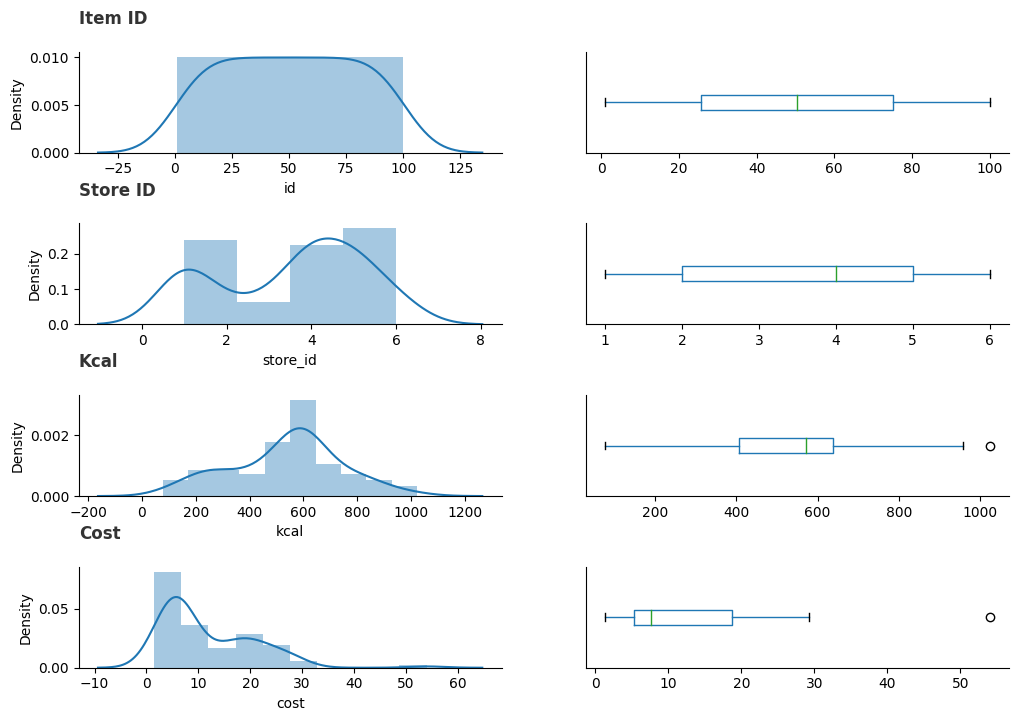

In [213]:
columns = ['id', 'store_id', 'kcal',  'cost']
titles  =['Item ID', 'Store ID', 'Kcal', 'Cost']

fig, axes = plt.subplots(nrows = len(columns), ncols = 2, figsize = (12,8))
plt.subplots_adjust(hspace = 0.7) # increase vertical space between graphs

for i, col in enumerate(columns):
  sns.distplot(items_df[col], ax = axes[i,0])
  items_df.boxplot(column = col, ax = axes[i,1], grid = False, vert = False)
  axes[i,0].set_title(titles[i], loc='left', fontweight='bold', color='#333333', pad=20)
  axes[i,1].set_yticks([])
  sns.despine()




Observations:
*****
 - There are outliers in 'kcal' and 'cost' fields that need to be treated
 - These cause a right tail in the distribution

*****
**Check distributions**
*****

In [214]:
items_df.describe()

id    store_id         kcal        cost
count  100.000000  100.000000   100.000000  100.000000
mean    50.500000    3.520000   536.730000   11.763700
std     29.011492    1.708446   202.212852    8.991254
min      1.000000    1.000000    78.000000    1.390000
25%     25.750000    2.000000   406.250000    5.280000
50%     50.500000    4.000000   572.500000    7.625000
75%     75.250000    5.000000   638.250000   18.790000
max    100.000000    6.000000  1023.000000   53.980000

Observations:
*****
- **'id'**: Is an identity column that follows perfect normal distribution as mean = median = 50.
Scales ranges from 1 - 100
- **'store_id'**: Has a slight left tail as mean is smaller than the median.
Scale ranges from 1 to 6.
- **'kcal'**: Has a left tail as mean is smaller than the median.
Scale ranges from 78 to 1023.
- **'cost'**: Has a right tail as mean is greater than the median.
Scale ranges from 1.3 to 53.9


Sclaing is required.

In [215]:
items_df.describe(include='object')

name
count          100
unique          94
top     Milky Cake
freq             3

Observations:
*****
- There are 94 unique items being sold.
- Milky Cake is the popular item available across aximum stores.

### **Data checks**

**2.   Restaurants**


*****
**Check data shape and size**
*****

In [216]:
restaurants_df.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6 non-null      int64 
 1   name    6 non-null      object
dtypes: int64(1), object(1)
memory usage: 581.0 bytes


Observations:
*****
- Number of observations: 6
- Number of columns: 2
- Data types:
          Numerical 1: 'id'
          Categorical 1: 'name'
- Data size: 581.0 bytes

*****
**Check for missing values**
*****

In [217]:
restaurants_df.isna().mean()

id      0.0
name    0.0
dtype: float64

Observations:
*****
There are no missing values in this dataset.

*****
**Check for outliers**
*****

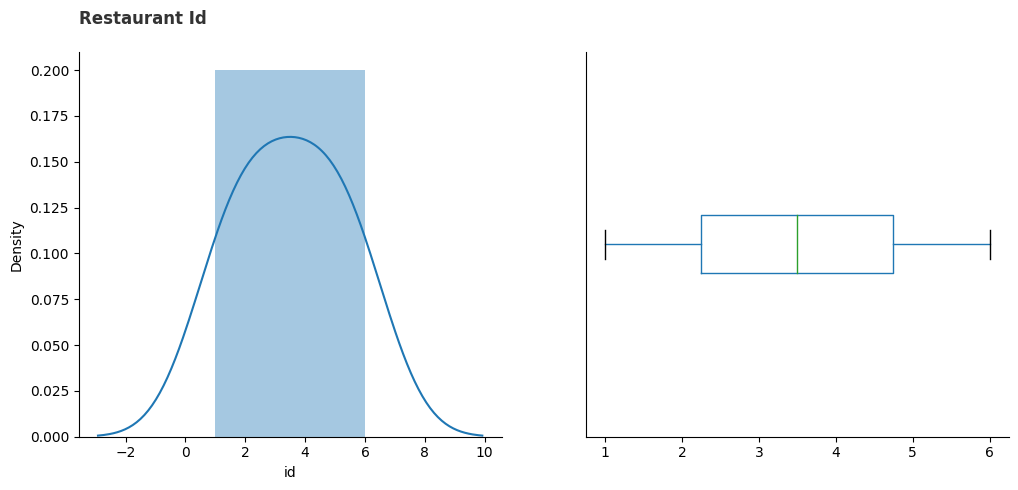

In [218]:
columns = ['id']
titles  = ['Restaurant Id']

fig, axes = plt.subplots(nrows = len(columns), ncols = 2, figsize = (12,5))
plt.subplots_adjust(hspace = 0.7)

for i, col in enumerate(columns):
  sns.distplot(restaurants_df[col], ax = axes[0])
  restaurants_df.boxplot(column = col, grid = False, vert = False, ax = axes[1])
  axes[0].set_title(titles[i], loc='left', fontweight='bold', color='#333333', pad=20)
  axes[1].set_yticks([])
  sns.despine()

Obervations:
*****
No outliers detected

*****
**Check distributions**
*****

In [219]:
restaurants_df.describe()

id
count  6.000000
mean   3.500000
std    1.870829
min    1.000000
25%    2.250000
50%    3.500000
75%    4.750000
max    6.000000

Observations:
*****
**'id'**: This is an identity column having normal distribution (mean = median). <br>
Scale ranges from 1 - 6

In [220]:
restaurants_df.describe(include='object')

name
count             6
unique            6
top     Bob's Diner
freq              1

Observations:
*****
There are 6 unique restaurants

### **Data checks**

**3.   Sales**

*****
**Check data shape and size**
*****

In [221]:
sales_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109600 entries, 0 to 109599
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        109600 non-null  datetime64[ns]
 1   item_id     109600 non-null  int64         
 2   price       109600 non-null  float64       
 3   item_count  109600 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 3.3 MB


Observations:
*****
- Number of oservations: 109600
- Number of columns: 4
- Data types:
        Numerical = 4 : 'item_id', 'price', 'item_count'
        Date      = 1: 'date'
- Data size: 3.3 MB

*****
**Check for missing values**
*****

In [222]:
sales_df.isna().mean()

date          0.0
item_id       0.0
price         0.0
item_count    0.0
dtype: float64

Observations:
****
There are no missing values in this dataset.


*****
**Check for outliers**
*****

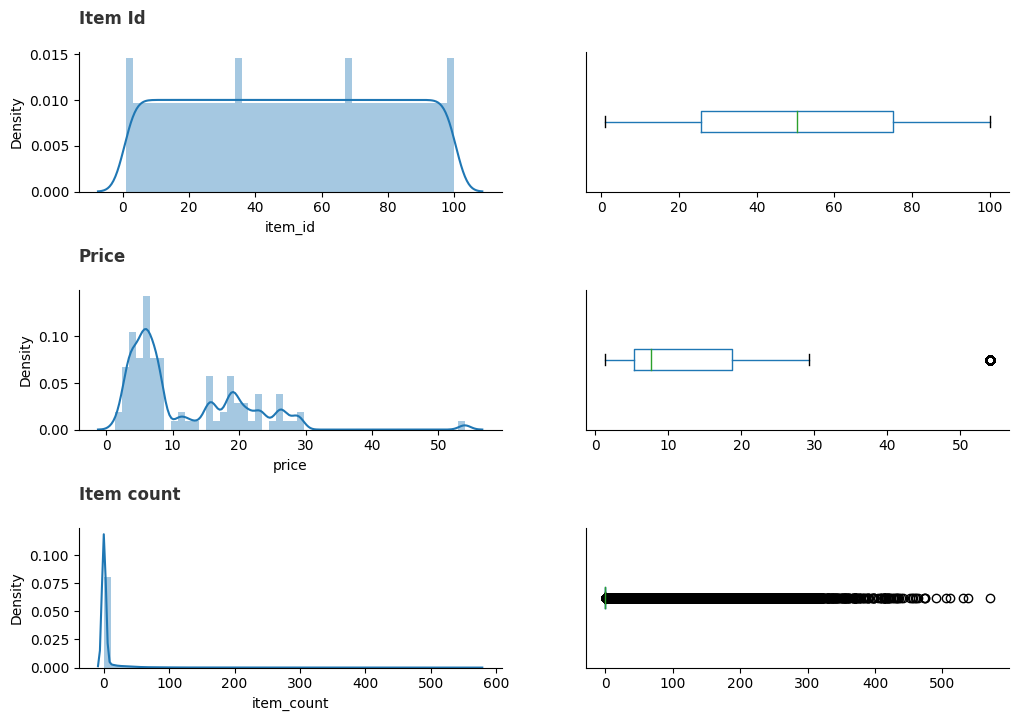

In [223]:
columns = ['item_id', 'price', 'item_count']
titles  = ['Item Id', 'Price', 'Item count']

fig, axes = plt.subplots(nrows = len(columns), ncols = 2, figsize=(12,8))
plt.subplots_adjust(hspace = 0.7)

for i, col in enumerate(columns):
  sns.distplot(sales_df[col], ax = axes[i,0])
  sales_df.boxplot(column = col, ax =axes[i,1], grid = False, vert = False)
  axes[i,0].set_title(titles[i], loc='left', fontweight='bold', color='#333333', pad=20)
  axes[i,1].set_yticks([])
  sns.despine()



Observations:
****
 'price' and 'item_count' contain outliers that need treatment.

****
**Check distributions**
****

In [224]:
sales_df.describe()

date        item_id          price     item_count
count               109600  109600.000000  109600.000000  109600.000000
mean   2020-07-01 12:00:00      50.500000      11.763700       6.339297
min    2019-01-01 00:00:00       1.000000       1.390000       0.000000
25%    2019-10-01 18:00:00      25.750000       5.280000       0.000000
50%    2020-07-01 12:00:00      50.500000       7.625000       0.000000
75%    2021-04-01 06:00:00      75.250000      18.790000       0.000000
max    2021-12-31 00:00:00     100.000000      53.980000     570.000000
std                    NaN      28.866202       8.946225      30.003728

Observations:
****
- **'date'**: Displays a normal distribution. <br>
Date range between 2019 - 2021 (3 years)
- **'item_id'**: Identity columns with normal distribution (mean = median = 50) <br>
 Scale ranges from 1 - 100
- **'price'**: Has a right tail as mean is greater then median. <br>
 Scale ranges from 1.3 - 53.9
- **'item_count'**: Has a right tail skew as mean is greater than the median. <br> Scale ranges from 0 - 570


Scaling is required



### **Merge the datasets into a single dataset**

In [225]:
sales_item = sales_df.merge(items_df, how='left', left_on = 'item_id', right_on = 'id' )
sales_merged = sales_item.merge(restaurants_df, how='left', left_on = 'store_id', right_on = 'id', suffixes = ('_sales', '_rest') )

# Drop unwanted columns
sales_merged.drop(columns = ['id_sales', 'id_rest','cost'], inplace = True)

# calculate sales
sales_merged['sales']  = sales_merged['item_count'] * sales_merged['price']

# Rename columns
sales_merged.rename(columns = {'name_sales':'item_name', 'name_rest':'store_name'}, inplace=True)

# Rearrange columns
sales_merged_with_outliers = sales_merged[['date', 'item_id', 'price', 'item_count', 'item_name', 'kcal', 'store_id', 'store_name', 'sales']]
sales_merged_with_outliers.head()

date  item_id  price  item_count                        item_name  \
0 2019-01-01        3  29.22         2.0                Sweet Fruity Cake   
1 2019-01-01        4  26.42        22.0  Amazing Steak Dinner with Rolls   
2 2019-01-01       12   4.87         7.0             Fantastic Sweet Cola   
3 2019-01-01       13   4.18        12.0          Sweet Frozen Soft Drink   
4 2019-01-01       16   3.21       136.0             Frozen Milky Smoothy   

   kcal  store_id   store_name   sales  
0   931         1  Bob's Diner   58.44  
1   763         1  Bob's Diner  581.24  
2   478         1  Bob's Diner   34.09  
3   490         1  Bob's Diner   50.16  
4   284         1  Bob's Diner  436.56

### **Treating outliers**

In [226]:
from feature_engine.outliers import Winsorizer

# Instatiate
capper = Winsorizer(
    capping_method = 'gaussian',
    tail = 'right',
    fold = 3,
    variables = ['kcal', 'price', 'item_count']
)

# Fit-Transform
sales_merged_no_outliers = capper.fit_transform(sales_merged_with_outliers)


# Rounding off item_count
sales_merged_no_outliers['item_count'] = round(sales_merged_no_outliers['item_count'])
sales_merged_no_outliers.head()

date  item_id  price  item_count                        item_name  \
0 2019-01-01        3  29.22         2.0                Sweet Fruity Cake   
1 2019-01-01        4  26.42        22.0  Amazing Steak Dinner with Rolls   
2 2019-01-01       12   4.87         7.0             Fantastic Sweet Cola   
3 2019-01-01       13   4.18        12.0          Sweet Frozen Soft Drink   
4 2019-01-01       16   3.21        96.0             Frozen Milky Smoothy   

   kcal  store_id   store_name   sales  
0   931         1  Bob's Diner   58.44  
1   763         1  Bob's Diner  581.24  
2   478         1  Bob's Diner   34.09  
3   490         1  Bob's Diner   50.16  
4   284         1  Bob's Diner  436.56

### **Generate necessary features for model development**

day of the week, quarter of the year, month, year, day of the month and total sales

In [227]:
# Create time series features

def create_ts_features(df):
  df['year']      = df['date'].dt.year
  df['quarter']   = df['date'].dt.quarter
  df['month']     = df['date'].dt.month
  df['day']       = df['date'].dt.day
  df['dayofyear'] = df['date'].dt.dayofyear
  df['dayofweek'] = df['date'].dt.dayofweek
  return df

sales_merged = sales_merged_no_outliers.copy()
create_ts_features(sales_merged)
sales_merged = sales_merged[['date', 'year',	'quarter', 'month',	'day', 'dayofyear', 'dayofweek',	'store_id',	'store_name', 'item_id', 'item_name', 'kcal', 'price', 'item_count', 'sales']]
sales_merged.head()

date  year  quarter  month  day  dayofyear  dayofweek  store_id  \
0 2019-01-01  2019        1      1    1          1          1         1   
1 2019-01-01  2019        1      1    1          1          1         1   
2 2019-01-01  2019        1      1    1          1          1         1   
3 2019-01-01  2019        1      1    1          1          1         1   
4 2019-01-01  2019        1      1    1          1          1         1   

    store_name  item_id                        item_name  kcal  price  \
0  Bob's Diner        3                Sweet Fruity Cake   931  29.22   
1  Bob's Diner        4  Amazing Steak Dinner with Rolls   763  26.42   
2  Bob's Diner       12             Fantastic Sweet Cola   478   4.87   
3  Bob's Diner       13          Sweet Frozen Soft Drink   490   4.18   
4  Bob's Diner       16             Frozen Milky Smoothy   284   3.21   

   item_count   sales  
0         2.0   58.44  
1        22.0  581.24  
2         7.0   34.09  
3        12.0   50.16  
4        96.0  436.56

## **Exploratory data analysis**

#### **1. Examining the overall date wise sales to understand the pattern**

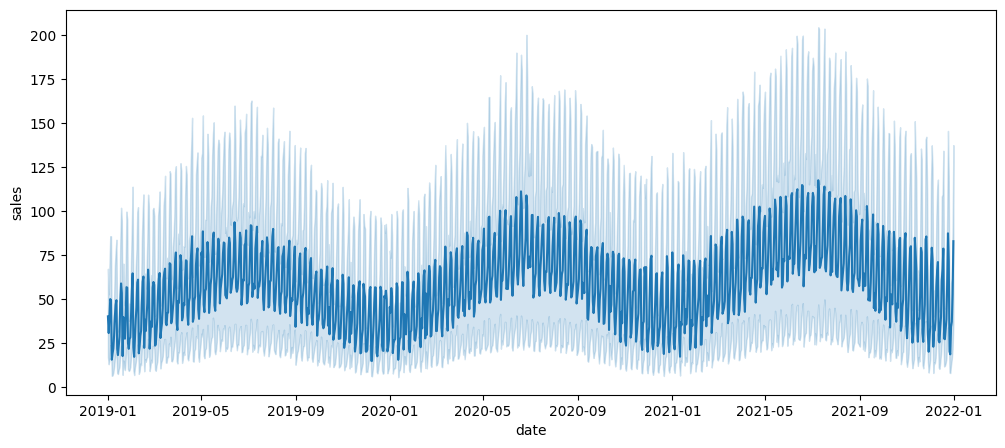

In [228]:
plt.figure(figsize=(12,5))
sns.lineplot(x=sales_merged['date'], y=sales_merged['sales'])
plt.show()

Observations:
****
- We see that the sales pattern is not very clear as there are daily entries for every month which is causing clutter.
- We will need to aggregate the data at monthly level for ease of use and efficient comparison.
- As of now we can infer there is a seasonal pattern observed across 3 years with sales being slow at the start of the year, peaks at mid-year and dips again at the year-end

#### **2. Sales fluctuation across different days of the week**

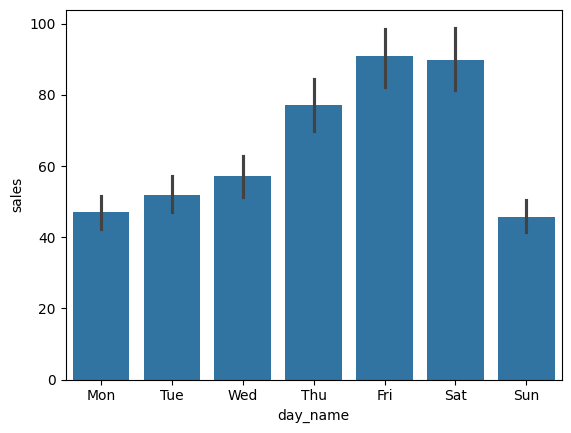

In [229]:
year = 2021
day = {
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun'
}

# create a subset of sales data for a single year 2021
sales_2021 = sales_merged[sales_merged['year'] == year]
sales_2021['day_name'] = sales_2021['dayofweek'].apply(lambda x: day.get(x))

day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.barplot(data = sales_2021, x = 'day_name', y = 'sales', order = day_order)
plt.show()

Observations:
****
- Sale is slow at the start of the week but gradually picks up as the week progresses.
- Friday & Saturday have the peak sales for the week.
- This is followed by a 50% drop in sales on Sunday.

#### **3. Trends in the sales data for different months of the year**

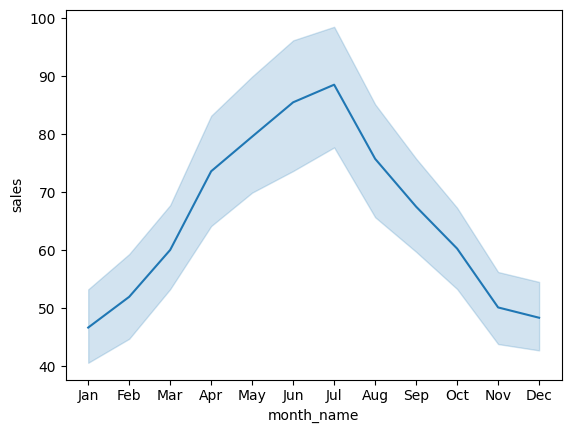

In [230]:
# Add month name to the dataset
month = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}
sales_2021['month_name'] = sales_merged['month'].apply(lambda x: month.get(x))

# Plot the graph
sns.lineplot(data = sales_2021, x = 'month_name', y = 'sales')
plt.show()

Observation:
****
- We see that sale is slow at the start of year but steadily picks up as the year progresses.
- We have high sales from April - September with June, July being the top-selling months.
- Sale steadily declines towards the end of the year with the lowest sale observed in December.

#### **4. Sales distribution across different quarters**

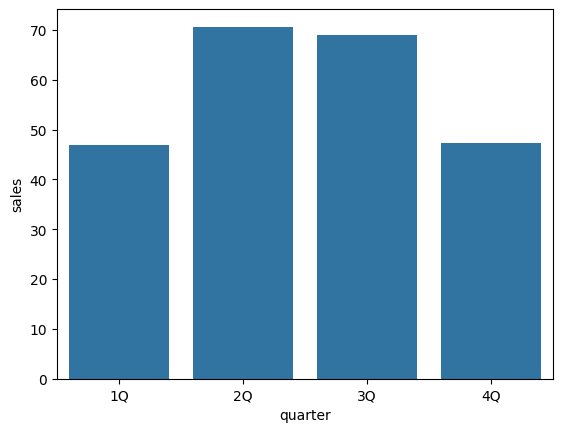

In [231]:
# calculating sales across different quarters averaged over the years
qtr_avg = pd.DataFrame(sales_merged.groupby('quarter')['sales'].mean()).reset_index()

# Plot the graph
sns.barplot(data = qtr_avg,
           x = qtr_avg.quarter.apply(lambda x: str(x)+'Q'),
           y = 'sales'
           )
plt.show()

Observations:
****
For the last 3 years we see that:
- Highest sales are observed in quarters 2 and 3
- Lowest sales are observed in quarters 1 and 4

#### **5. Comparing the performances of the different restaurants**

**Finding out which restaurant had the most sales**

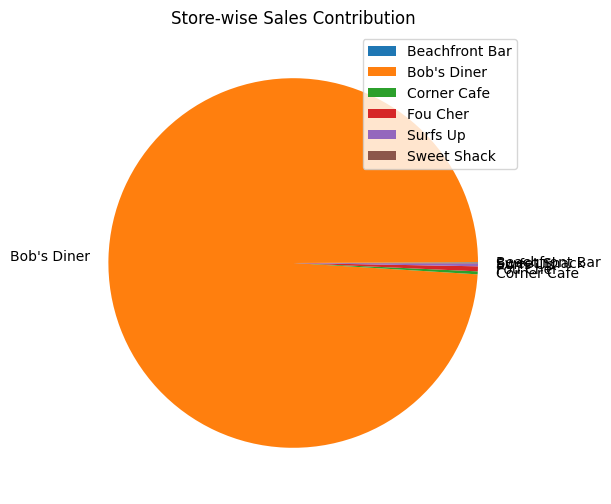

In [232]:
store_sales = pd.DataFrame(sales_merged.groupby(['store_name'])['sales'].sum()).reset_index()

# compute percentage sales
total_sales = store_sales['sales'].sum()
store_sales['percentages'] = (store_sales['sales']/ total_sales) * 100


# Plot the pie
plt.figure(figsize=(6,6))
plt.pie(store_sales['percentages'], labels = store_sales['store_name'], autopct='')
plt.legend(loc='best')
plt.title('Store-wise Sales Contribution')
plt.show()

Observations:
****
- Bob's Diner clearly has had the most sales across all 3 years

**Comparing sales for each restaurant across different years, months, and days**

In [233]:
# Let's build aggregated subsets before plotting the graphs

store_list = ["Bob's Diner", 'Beachfront Bar','Corner Cafe','Fou Cher', 'Surfs Up', 'Sweet Shack']

# calculate yearly sales in thousands (K)
store_sales_year = pd.DataFrame(sales_merged.groupby(['store_name','year'])['sales'].sum()).reset_index()
store_sales_year['sales_K'] = round(store_sales_year['sales']/1000)

# calculate monthly avg
store_sales_month = pd.DataFrame(sales_merged.groupby(['store_name','month'])['sales'].mean()).reset_index()


# calculate daily avg
store_sales_day = pd.DataFrame(sales_merged.groupby(['store_name','day'])['sales'].mean()).reset_index()



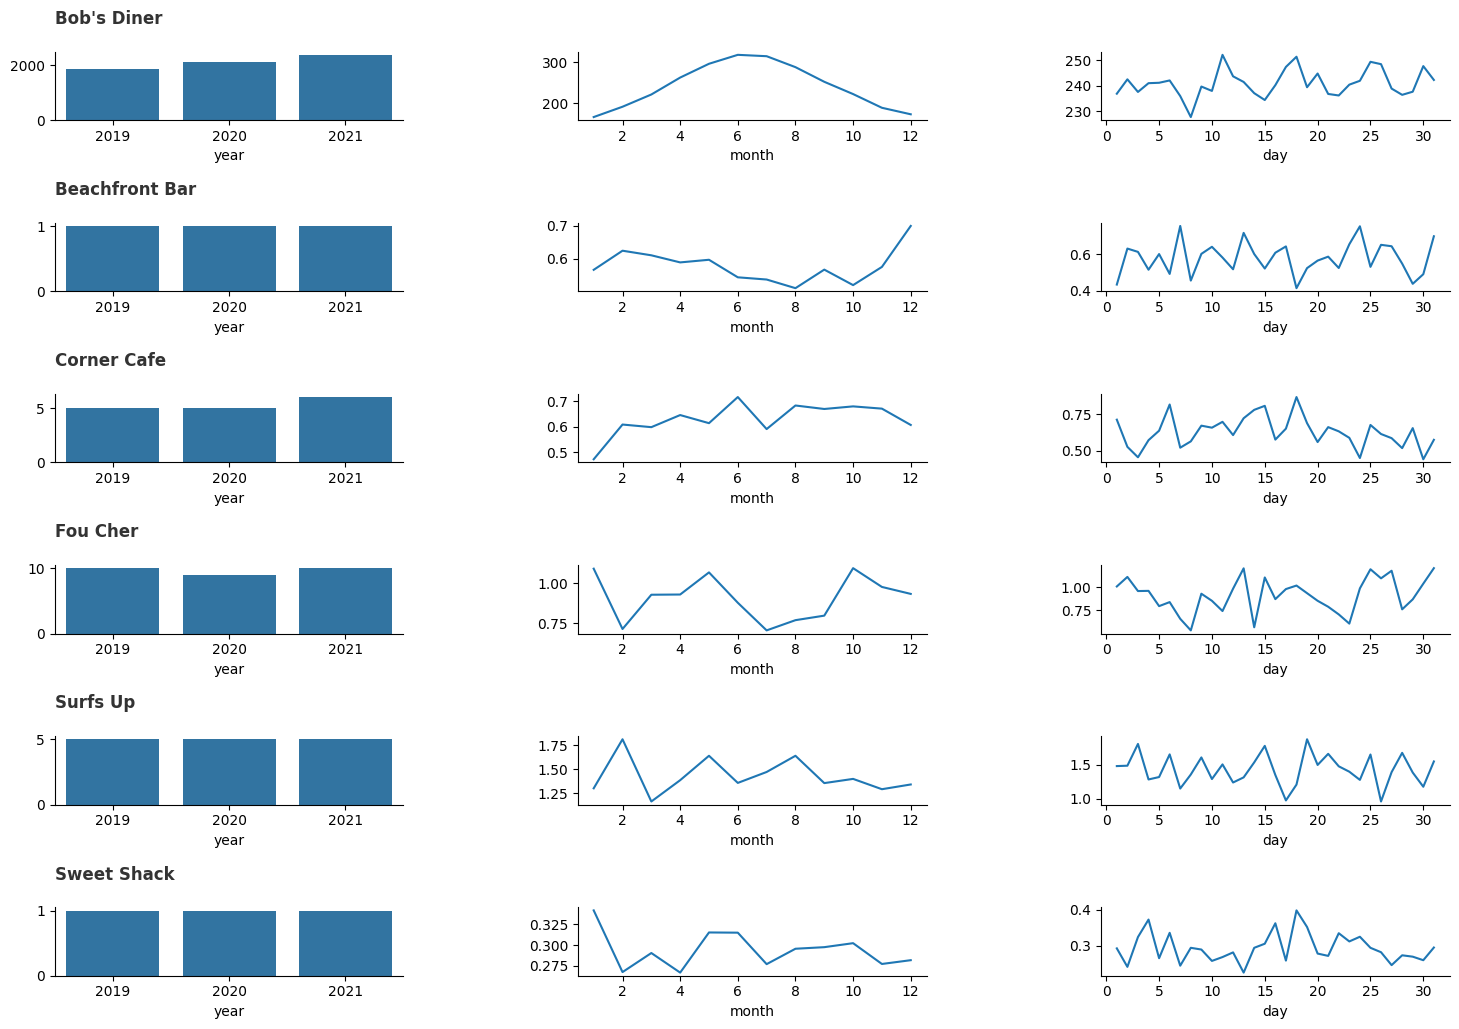

In [234]:
# Let's plot the comparison graph

fig, axes = plt.subplots(nrows = len(store_list), ncols = 3, figsize=(18,12))
plt.subplots_adjust(hspace=1.5, wspace=0.5)

for i, store in enumerate(store_list):
  sns.barplot(data = store_sales_year[store_sales_year['store_name'] == store], x = 'year', y = 'sales_K', ax = axes[i,0])
  sns.lineplot(data = store_sales_month[store_sales_month['store_name'] == store], x = 'month', y = 'sales', ax = axes[i,1])
  sns.lineplot(data = store_sales_day[store_sales_day['store_name'] == store], x = 'day', y = 'sales', ax = axes[i,2])

  axes[i,0].set_title(store_list[i], loc='left', fontweight='bold', color='#333333', pad=20)
  axes[i,0].set_ylabel('')
  axes[i,1].set_ylabel('')
  axes[i,2].set_ylabel('')

  sns.despine()

plt.show()

Observations:
****
- Since Bob's Diner contributes 98% of the sales, we see the the same bell curve over the months where sales peaks at mid-year but falls at the start and end of the year.
- On the other hand, the remaining cafe's show a dip in sales during Jun-Jul.
- Beachfront Bar shows a sales surge in the last quater, peaking in December.
- The daily trend shows constant fluctuation in sales across different days.
  


#### **6. Identifying the most popular items**

**Fetching the top 10 most popular items overall**

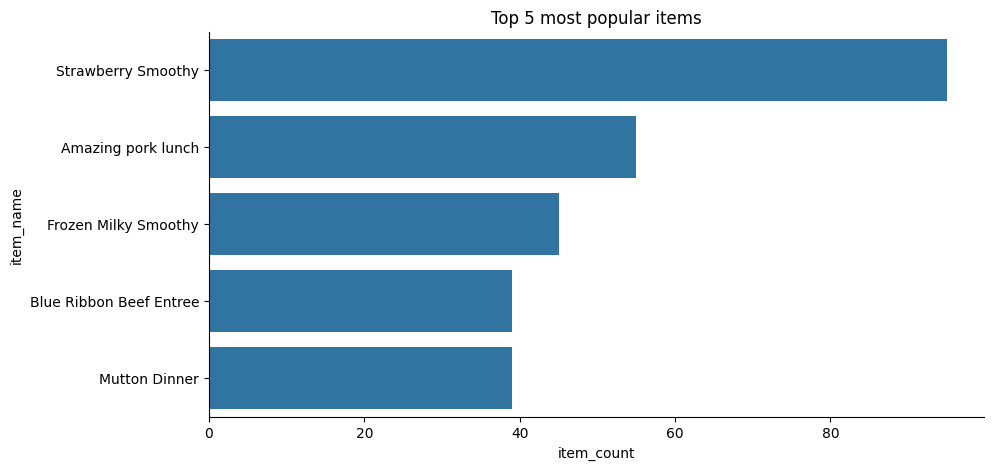

In [235]:
# compute how many times an item has been purchased on an avg. in the last 3 years
top5_items = pd.DataFrame(round(sales_merged.groupby(['item_id','item_name'])['item_count'].mean())).reset_index()
top5_items = top5_items.sort_values('item_count', ascending=False).head(5).reset_index().drop('index', axis=1) # fetch top 10 items


plt.figure(figsize=(10,5))
sns.barplot(data = top5_items, y = 'item_name', x = 'item_count')
plt.title('Top 5 most popular items')
sns.despine()
plt.show()

**Which are the stores selling the most popular items**

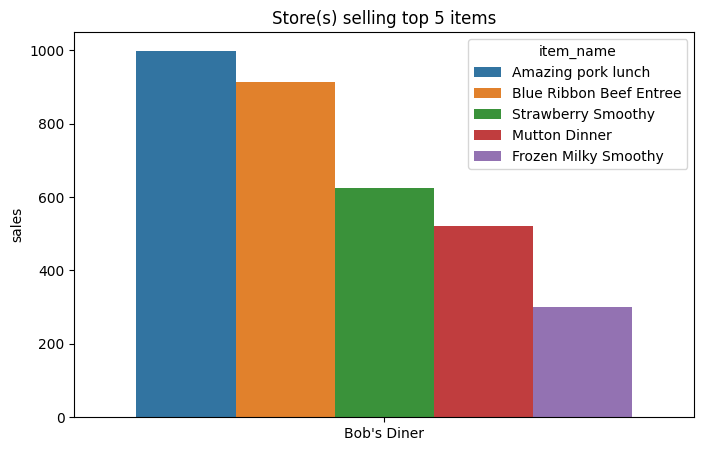

In [236]:
x = sales_merged[sales_merged['item_id'].isin(top5_items.item_id)]
x = pd.DataFrame(x.groupby(['store_name','item_name'])['sales'].mean()).reset_index()
x = x.sort_values('sales', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=x, x='store_name', y='sales', hue='item_name')
plt.xlabel('')
plt.title('Store(s) selling top 5 items')
plt.show()

Observations:
****
Bob's Diner is the only store selling the 5 most popular items

**Finding out the most popular item at each store**

In [237]:
# create the aggregate dataset

top5_store = pd.DataFrame()
for i, store in enumerate(store_list):
  store_sales = sales_merged[sales_merged['store_name'] == store]
  top5_items = pd.DataFrame(round(store_sales.groupby(['store_name', 'item_name'])[['item_count', 'sales']].sum())).reset_index()
  y = top5_items.sort_values('item_count', ascending=False).head(5).reset_index().drop('index', axis=1)
  top5_store = pd.concat([top5_store, y])

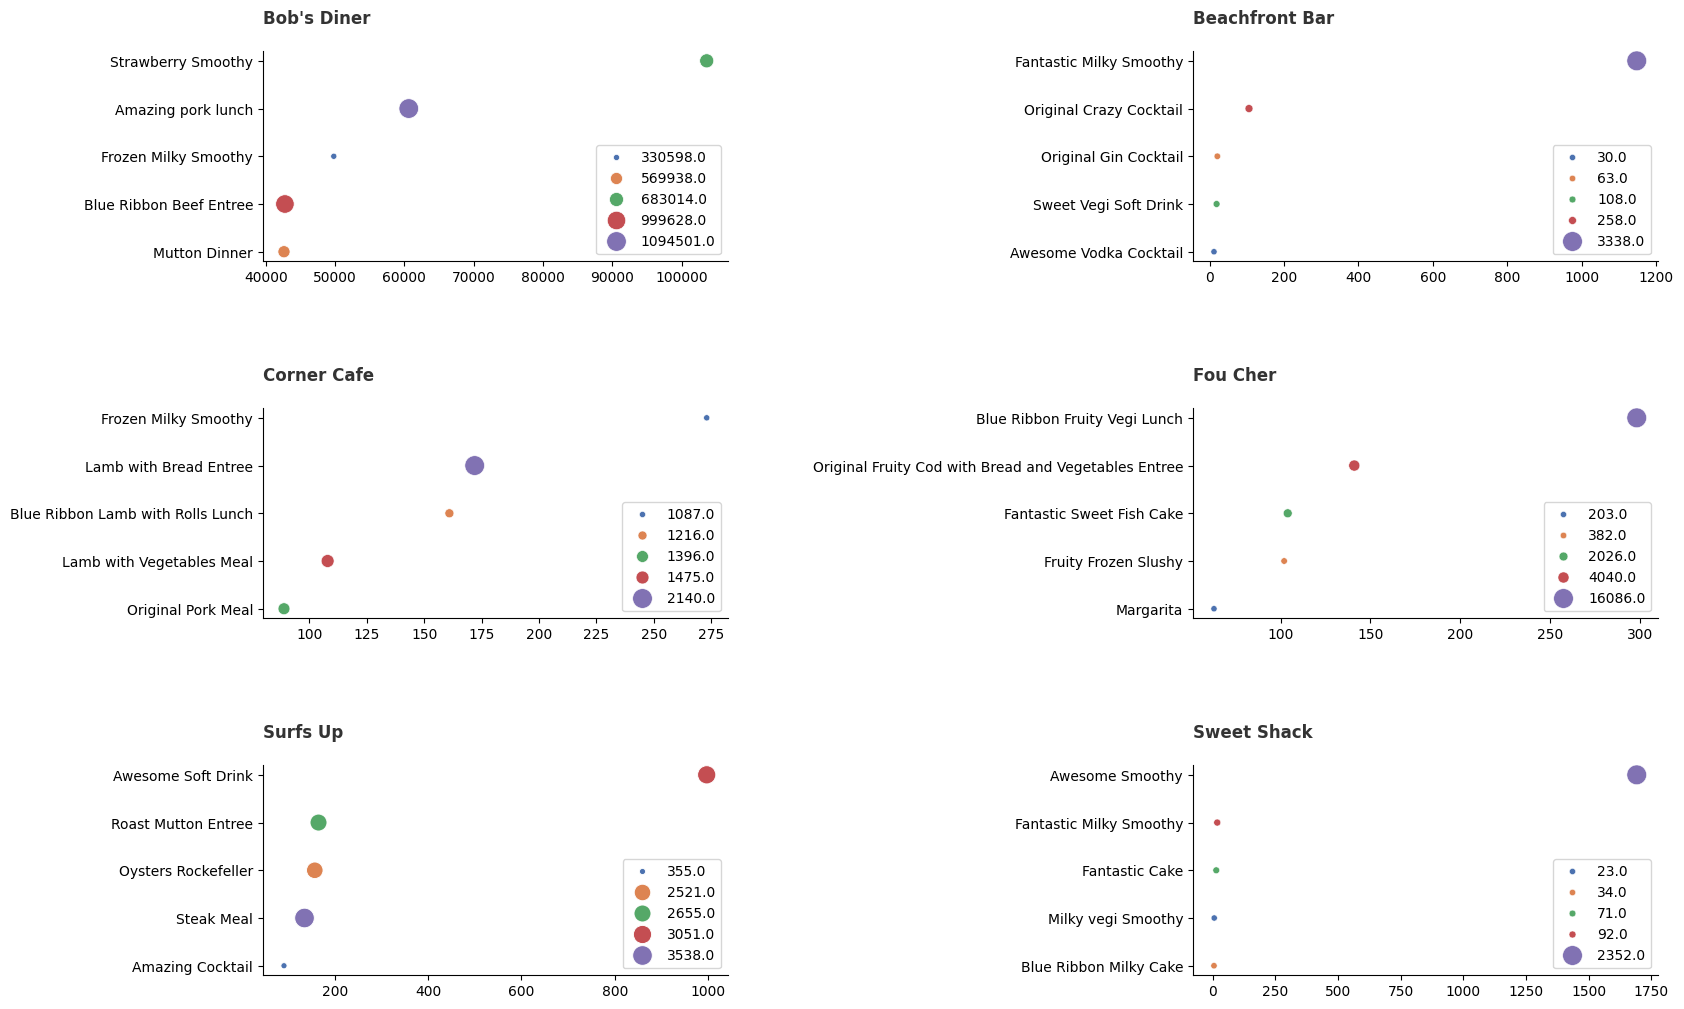

In [238]:
# plot the top 5 items at each store by number of items sold. Size of the bubble indicates total sales value

plt.figure(figsize=(18,12))
plt.subplots_adjust(hspace=0.7, wspace=1)

for i, store in enumerate(store_list):
  plt.subplot(3,2,i+1)
  sns.scatterplot(data = top5_store[top5_store.store_name == store],
                y = 'item_name',
                x = 'item_count',
                size = 'sales',
                sizes = (20, 200),
                hue = 'sales' ,
                palette = 'deep',
                )
  plt.ylabel('')
  plt.xlabel('')
  plt.title(store, loc='left', fontweight='bold', color='#333333', pad=20)
  plt.legend(loc='lower right')
  sns.despine()
plt.show()

#### **7. Check if the store with the highest sales volume is also making the most money per day**

In [239]:
# creating the data subset
x = pd.DataFrame(sales_merged.groupby(['store_name','dayofweek'])[['item_count', 'sales']].mean()).reset_index()
x['day_name'] = x['dayofweek'].apply(lambda x: day.get(x))

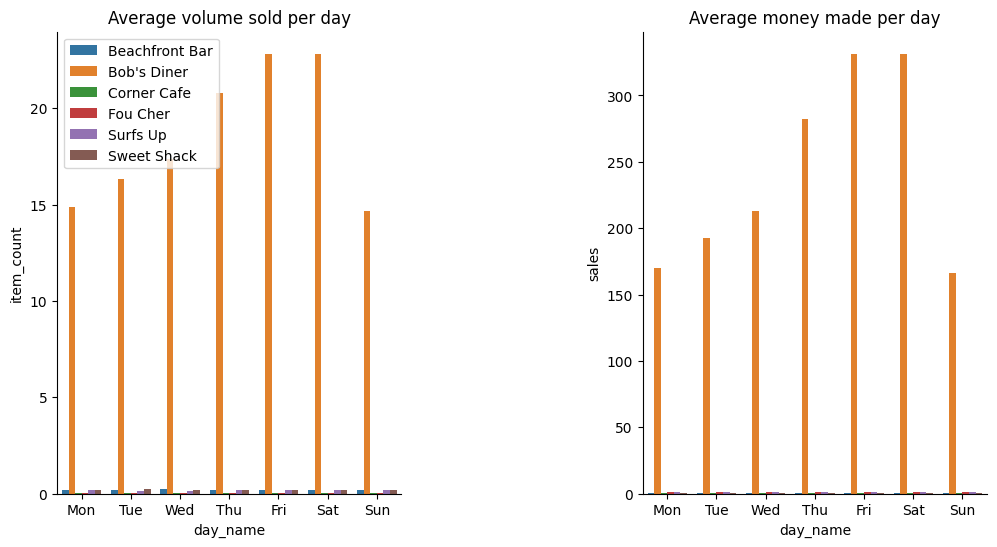

In [240]:
# plot the graph
plt.figure(figsize=(12,6))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,2,1)
sns.barplot(data = x, x = 'day_name', y = 'item_count', hue='store_name')
plt.legend(loc='upper left')
plt.title('Average volume sold per day')

plt.subplot(1,2,2)
sns.barplot(data = x, x = 'day_name', y = 'sales', hue='store_name', legend=None)
plt.title('Average money made per day')

sns.despine()
plt.show()

Observations:
****
It is clear that Bob's Diner having the highest sales volume is also making the most money per day.

#### **8. Identifying the most expensive item at each restaurant and its calorie count**

In [241]:
# creating a subset containing the most expensive items at each store
exp_items_store = pd.DataFrame()
for i, store in enumerate(store_list):
  store_sales = sales_merged[sales_merged['store_name'] == store]
  exp_items = pd.DataFrame(store_sales.groupby(['store_name', 'item_name'])[['price', 'kcal']].max()).reset_index()
  y = exp_items.sort_values('price', ascending=False).head(1).reset_index().drop('index', axis=1)
  exp_items_store = pd.concat([exp_items_store, y])

exp_items_store = exp_items_store.sort_values('price', ascending = False)

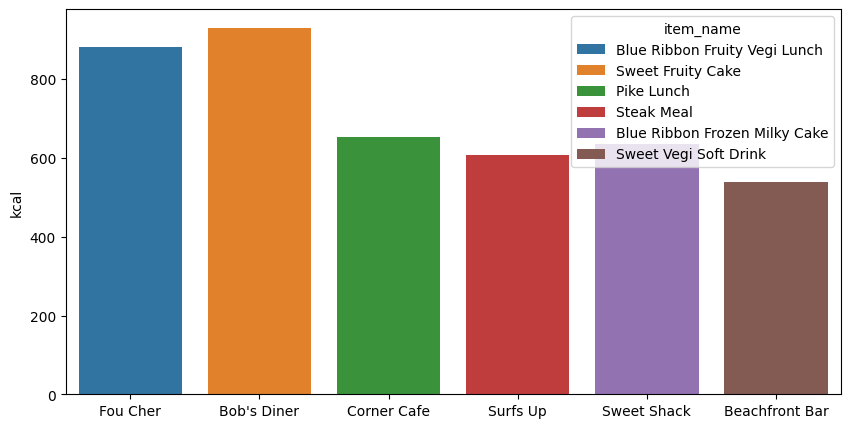

In [242]:
# plotting a grpah that show the most expensive items in descending order of their price.
# the graph also depicts calories in these dishes

plt.figure(figsize=(10,5))
sns.barplot(data = exp_items_store,
            x = 'store_name',
            y = 'kcal',
            hue = 'item_name'
            )
plt.xlabel('')
plt.show()

Observations:
****
- The top selling item at Fou Cher is more expensive that that at Bob's Diner but has fewer calories.
- Hiher priced items do not necessarily mean higher calories.

## **Forecasting using machine learning algorithms**

#### **Data preparation**

In [243]:
fc_data = sales_merged[['date', 'year',	'quarter',	'month',	'day',	'dayofyear', 'dayofweek', 'store_id', 'item_count']]


# create daily aggregates for each store
fc_daily_agg = pd.DataFrame(round(fc_data.groupby(['date', 'year',	'quarter',	'month',	'day',	'dayofyear', 'dayofweek', 'store_id'])['item_count'].mean())).reset_index()
fc_daily_agg = fc_daily_agg.set_index('date')
fc_daily_agg.sort_index(inplace=True) # sort dates


# create monthly aggregates for each store
fc1_agg = pd.DataFrame(fc_daily_agg.groupby(['year',	'month', 'store_id'])['item_count'].mean()).reset_index()
# add day column
fc1_agg['day'] = 1
# create date
fc1_agg['date'] = pd.to_datetime(fc1_agg[['year',	'month','day']])
# store-wise monthly aggregate
fc1_agg = fc1_agg[['date','store_id', 'item_count']]
# create additional time series features
create_ts_features(fc1_agg)
fc1_agg = fc1_agg[['date','year',	'quarter',	'month',	'day',	'dayofyear', 'dayofweek', 'store_id', 'item_count']].set_index('date')
fc1_agg.head()

year  quarter  month  day  dayofyear  dayofweek  store_id  \
date                                                                    
2019-01-01  2019        1      1    1          1          1         1   
2019-01-01  2019        1      1    1          1          1         2   
2019-01-01  2019        1      1    1          1          1         3   
2019-01-01  2019        1      1    1          1          1         4   
2019-01-01  2019        1      1    1          1          1         5   

            item_count  
date                    
2019-01-01   13.580645  
2019-01-01    0.000000  
2019-01-01    0.000000  
2019-01-01    0.000000  
2019-01-01    0.000000

In [244]:
# Splitting data into train and test. We will take the last 6 months as test data
split_date = '2021-07-01'
train = fc1_agg.loc[fc1_agg.index < split_date].copy()
test  = fc1_agg.loc[fc1_agg.index >= split_date].copy()

print('Train data range: ', min(train.index) ,'-', max(train.index))
print('Test data range : ', min(test.index) ,'-', max(test.index))

Train data range:  2019-01-01 00:00:00 - 2021-06-01 00:00:00
Test data range :  2021-07-01 00:00:00 - 2021-12-01 00:00:00


**Visualizing train and test data for each store**

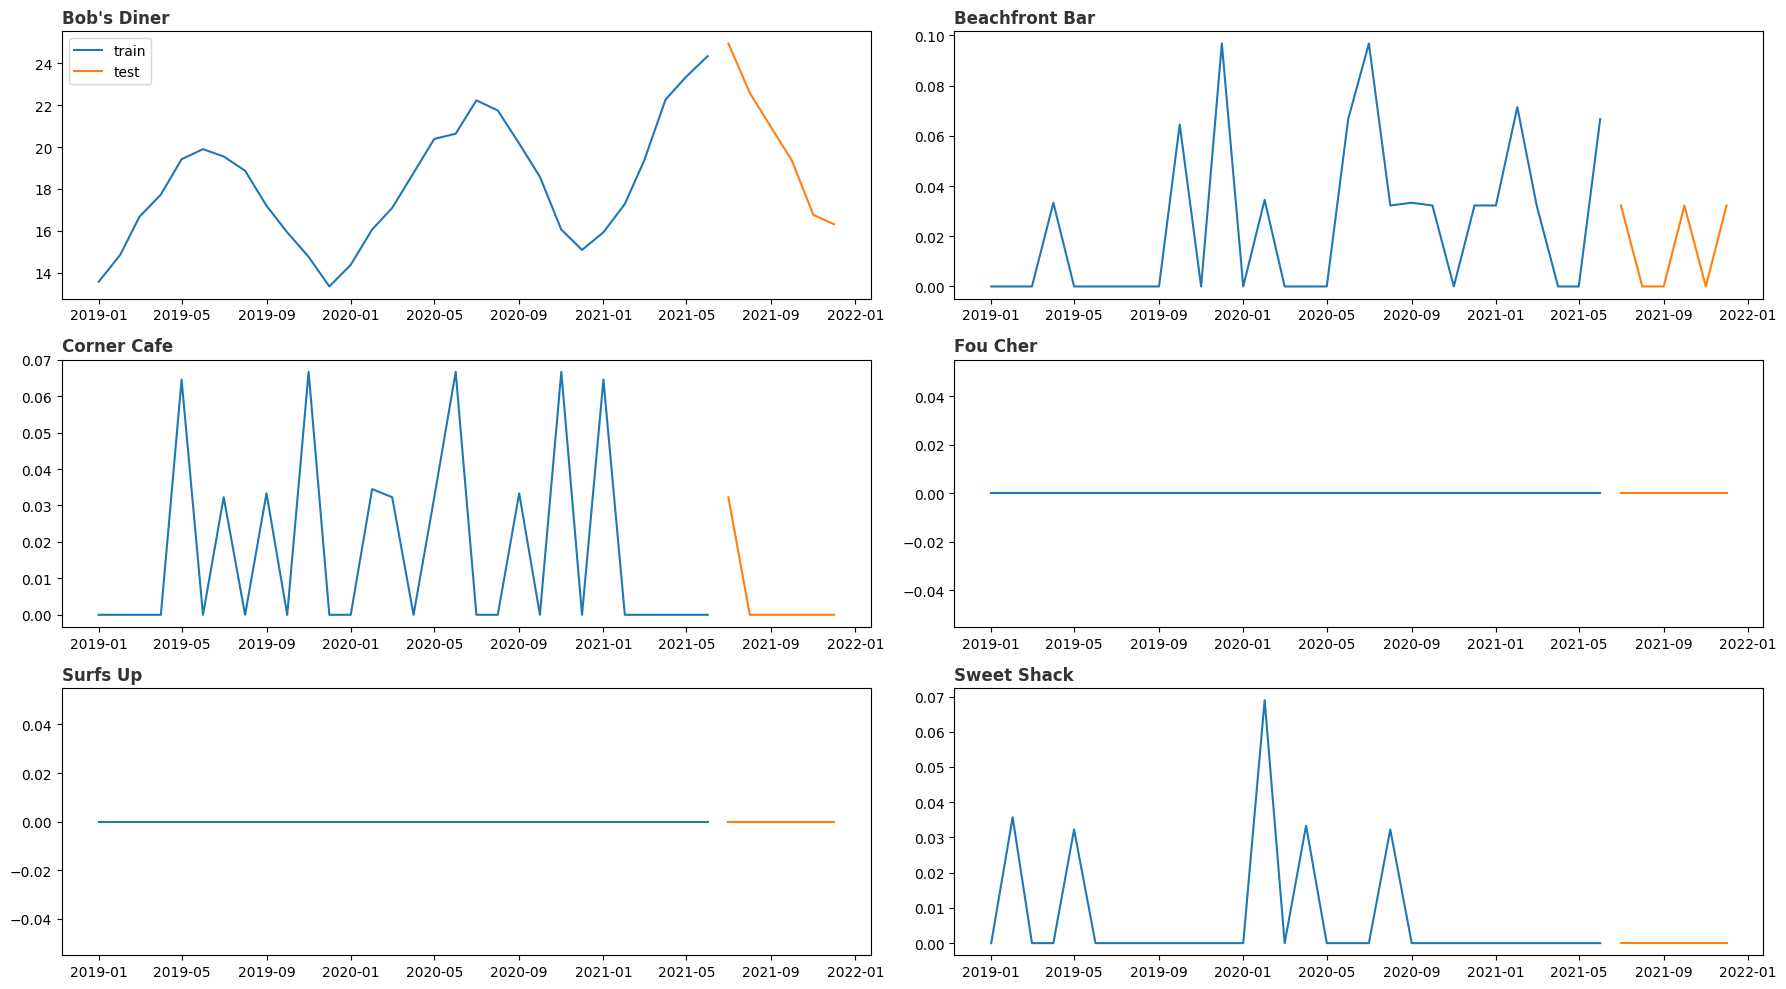

In [245]:
# Creating a figure
fig, axs = plt.subplots(3,2, figsize=(18, 10))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Adding subplots in a loop
for i, store in enumerate(store_list):
    train_plt = train[train['store_id'] == i+1]
    test_plt  = test[test['store_id'] == i+1]

    axs[i].plot(train_plt.index, train_plt.item_count, label='train')
    axs[i].plot(test_plt.index, test_plt.item_count, label='test')
    axs[i].set_title(store, loc='left', fontweight='bold', color='#333333')
    axs[0].legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

#### **Comparing Linear Regression, Random Forest Classifier and XGBoost**

In [246]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Instantiate
xgb_model = xgb.XGBRegressor(n_estimators = 1000)
lr_model = LinearRegression()
rfc_model = RandomForestRegressor(n_estimators = 1000, max_depth=5, random_state=123, min_samples_split=5)

# Define algorithms to try
algorithms = [
    ('LinearRegression', lr_model),
    ('RandomForest', rfc_model),
    ('XGBoost', xgb_model),
]


# Define a function to evaluate model performance
def evaluate_model(store, name, model, X_train, X_test, y_train, y_test):
  start_time = time.time()
  # Fit
  model.fit(X_train, y_train)
  # Predict
  y_test_pred = model.predict(X_test)
  # Evaluate
  rmse = round(np.sqrt(mean_squared_error(y_test, y_test_pred)),3)
  runtime = time.time() - start_time

  metrics=[]
  metrics.append(
      {
          'Store' : store,
          'Algorithm' : name,
          'Root Mean Squared Error' : rmse,
          'Runtime (in secs)' : runtime
      }
  )
  return pd.DataFrame(metrics)


# Evaluate individual model performance for each store

model_comparison = pd.DataFrame()
for i, store_name in enumerate(store_list):
  train_store = train[train['store_id']==i+1].drop('store_id', axis=1)
  test_store = test[test['store_id']==i+1].drop('store_id', axis=1)

  # split the train and test datasets into X and y variables
  X_train, y_train = train_store.drop('item_count', axis=1), train_store['item_count']
  X_test, y_test   = test_store.drop('item_count', axis=1), test_store['item_count']

  for name, model in algorithms:
    metrics =  evaluate_model(store_name, name, model, X_train, X_test, y_train, y_test)
    model_comparison = pd.concat([model_comparison, metrics], axis = 0)

model_comparison

Store         Algorithm  Root Mean Squared Error  \
0     Bob's Diner  LinearRegression                    3.450   
0     Bob's Diner      RandomForest                    1.149   
0     Bob's Diner           XGBoost                    1.821   
0  Beachfront Bar  LinearRegression                    0.039   
0  Beachfront Bar      RandomForest                    0.030   
0  Beachfront Bar           XGBoost                    0.023   
0     Corner Cafe  LinearRegression                    0.019   
0     Corner Cafe      RandomForest                    0.022   
0     Corner Cafe           XGBoost                    0.028   
0        Fou Cher  LinearRegression                    0.000   
0        Fou Cher      RandomForest                    0.000   
0        Fou Cher           XGBoost                    0.000   
0        Surfs Up  LinearRegression                    0.000   
0        Surfs Up      RandomForest                    0.000   
0        Surfs Up           XGBoost                    0.000   
0     Sweet Shack  LinearRegression                    0.007   
0     Sweet Shack      RandomForest                    0.004   
0     Sweet Shack           XGBoost                    0.002   

   Runtime (in secs)  
0           0.009614  
0           1.774468  
0           2.799378  
0           0.042825  
0           1.610173  
0           0.137608  
0           0.004484  
0           1.123541  
0           0.129682  
0           0.006117  
0           1.128829  
0           0.133886  
0           0.004126  
0           1.132962  
0           0.138709  
0           0.004008  
0           1.106282  
0           0.133504

#### **ARIMA Model**

##### **Checking whether the time series data is stationary or not**

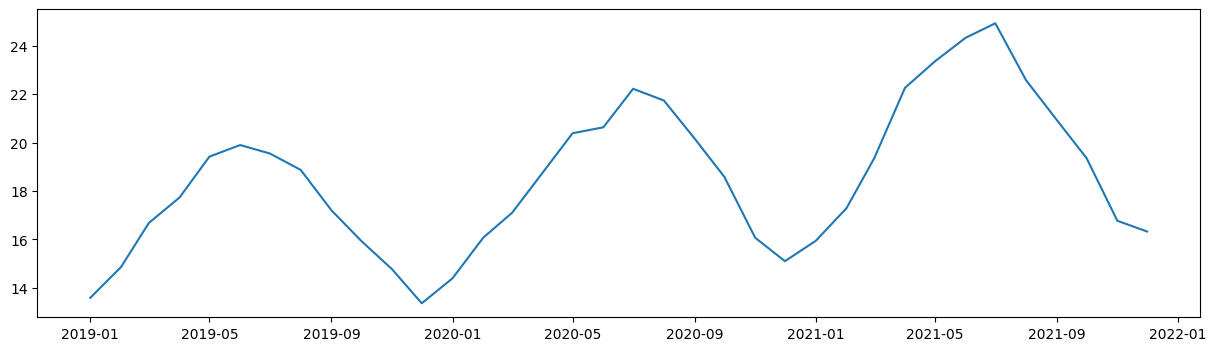

In [247]:
# For Store 1
data = pd.DataFrame(fc1_agg[fc1_agg.store_id == 1]['item_count'], columns=['item_count'])
plt.figure(figsize=(15,4))
plt.plot(data)
plt.show()


In [248]:
# Check for stationarity of time series using Augmented Dickey Fuller test (ADF)

from statsmodels.tsa.stattools import adfuller

def test_stationarity(df):
  # Dickey Fuller test:
  df_test = adfuller(df)

  print('Results of Dickey Fuller test:')
  # 0 - 3rd element
  df_output = pd.Series(df_test[0:4], index=['Test statistic',
                                   'p-value',
                                   '#Lags used',
                                   '#Observations used']
                        )

  # 4th element - dict
  for key, value in df_test[4].items():
    df_output['Critical value (%s)' %key] = value

  print(df_output)

In [249]:
test_stationarity(data)

Results of Dickey Fuller test:
Test statistic          -0.232962
p-value                  0.934477
#Lags used               8.000000
#Observations used      27.000000
Critical value (1%)     -3.699608
Critical value (5%)     -2.976430
Critical value (10%)    -2.627601
dtype: float64


Observations:
****

**Null hypothesis:** The time series data is not stationary <br>
**Alternate hypothesis:** The the time series data is stationary

1) Based on p-value
- p-value > 0.05: Accept Null hypothesis
- p-value <= 0.05: Accept Alternate hypothesis

2) Based on test statistic and critical value
- test statistic > critical value (5%): Accept Null hypothesis
- test statistic < critical value (5%): Accept Alternate hypothesis

**From the above test values, we infer that out dataset is not stationary.**

**Since our time series is not stationary and has seasonality, we will use Seasonal ARIMA (SARIMA)**

##### **1. Log Transformation**

In [250]:
# prepare data for log transformation
data = fc1_agg.reset_index()
data = data[['date','store_id','item_count']].set_index(['date','store_id'])
data.head()

item_count
date       store_id            
2019-01-01 1          13.580645
           2           0.000000
           3           0.000000
           4           0.000000
           5           0.000000

In [251]:
# applying log transform on entire data
log_data = np.log(data).reset_index()
log_data.set_index('date', inplace=True)
log_data['item_count'].replace(-np.inf, 0, inplace=True) # replace - infinity values with zero
log_data.head()


store_id  item_count
date                            
2019-01-01         1    2.608646
2019-01-01         2    0.000000
2019-01-01         3    0.000000
2019-01-01         4    0.000000
2019-01-01         5    0.000000

In [252]:
# Splitting data into train and test. We will take the last 6 months as test data
split_date = '2021-07-01'
train = log_data.loc[log_data.index < split_date].copy()
test  = log_data.loc[log_data.index >= split_date].copy()
train.head()

store_id  item_count
date                            
2019-01-01         1    2.608646
2019-01-01         2    0.000000
2019-01-01         3    0.000000
2019-01-01         4    0.000000
2019-01-01         5    0.000000

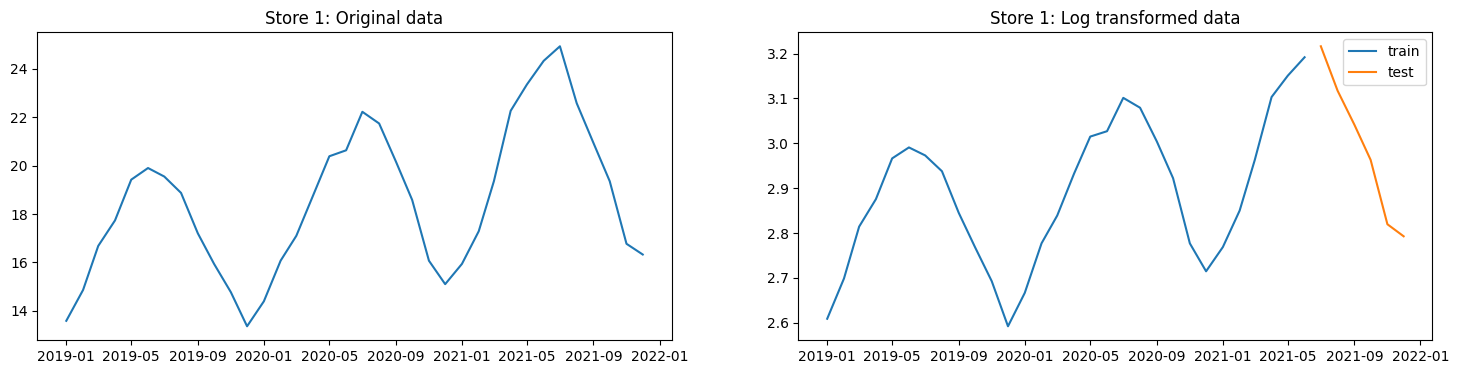

In [253]:
# Plotting original and log transformed data for store 1
orig_store1 = fc1_agg[fc1_agg.store_id==1]
train_store1 = train[train.store_id==1]
test_store1 = test[test.store_id==1]

plt.figure(figsize=(18,4))

plt.subplot(1,2,1)
plt.plot(orig_store1.index, orig_store1.item_count)
plt.title('Store 1: Original data')


plt.subplot(1,2,2)
plt.plot(train_store1.index, train_store1.item_count, label='train')
plt.plot(test_store1.index, test_store1.item_count, label='test')
plt.title('Store 1: Log transformed data')
plt.legend()
plt.show()

##### **2. Differencing**

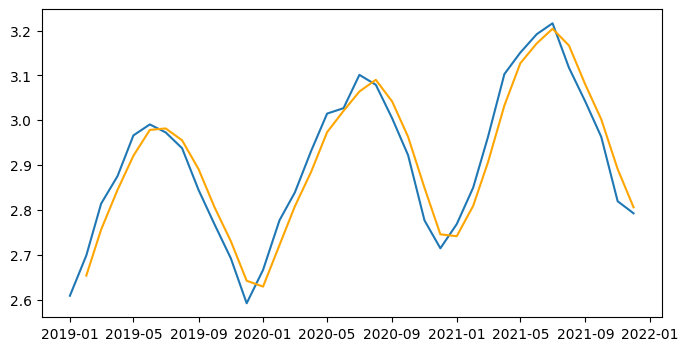

In [254]:
log_store1 = log_data[log_data.store_id==1]['item_count']
moving_avg = log_store1.rolling(window=2).mean()

plt.figure(figsize=(8,4))
plt.plot(log_store1)
plt.plot(moving_avg, color='orange')
plt.show()

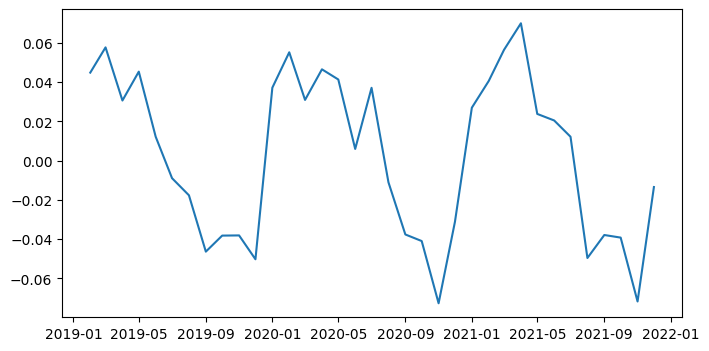

In [255]:
# calculate difference between moving avg and actual item count

ts_log_mv_diff = log_store1 - moving_avg

# remove nulls
ts_log_mv_diff.dropna(inplace=True)

plt.figure(figsize=(8,4))
plt.plot(ts_log_mv_diff)
plt.show()

**Re-checking for stationarity**

In [256]:
test_stationarity(ts_log_mv_diff)

Results of Dickey Fuller test:
Test statistic          -3.970580
p-value                  0.001573
#Lags used               9.000000
#Observations used      25.000000
Critical value (1%)     -3.723863
Critical value (5%)     -2.986489
Critical value (10%)    -2.632800
dtype: float64


Observations:
****
- p-value < 0.05
- test statistic < critical value at 5%
- Hence, we infer that the time series data is now stationarized.

##### **Plotting the ACF and PACF curves to find p and q values**

In [257]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf  = acf(ts_log_mv_diff, nlags = 10)
lag_pacf = pacf(ts_log_mv_diff, nlags = 10, method='ols')

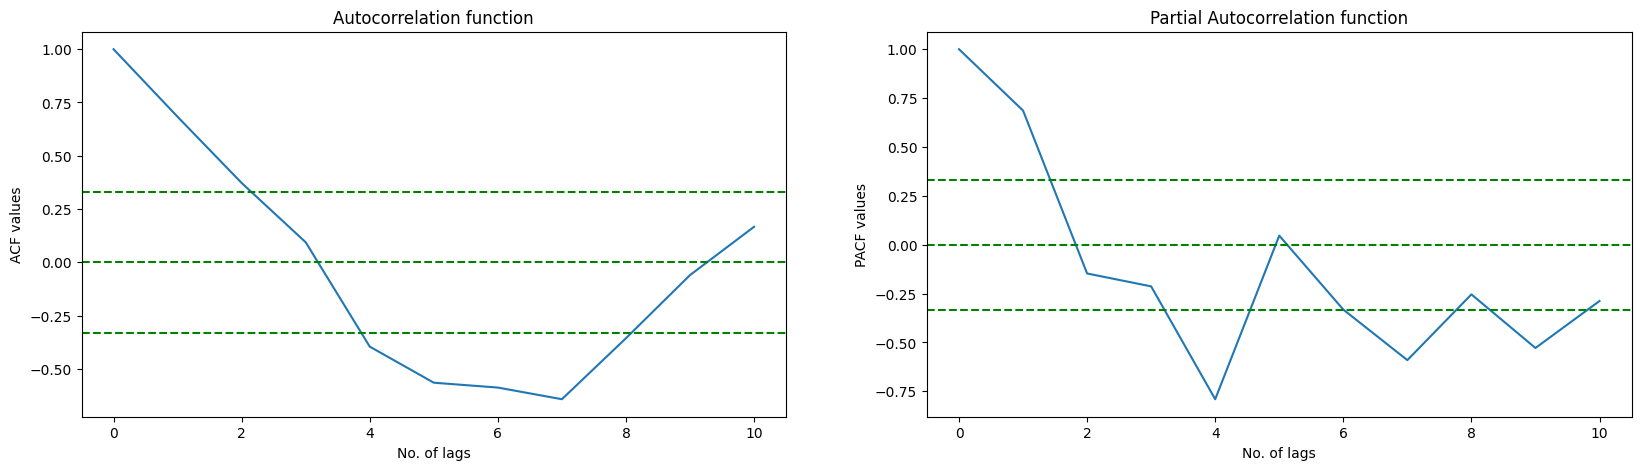

In [258]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(lag_acf)
# draw zero line
plt.axhline(y = 0, linestyle='--', color='green')
# draw upper confidence interval
plt.axhline(y = 1.96/ np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='green')
# draw lower confidence interval
plt.axhline(y = -1.96/ np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='green')
plt.title('Autocorrelation function')
plt.xlabel('No. of lags')
plt.ylabel('ACF values')


plt.subplot(1,2,2)
plt.plot(lag_pacf)
# draw zero line
plt.axhline(y = 0, linestyle='--', color='green')
# draw upper confidence interval
plt.axhline(y = 1.96/ np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='green')
# draw lower confidence interval
plt.axhline(y = -1.96/ np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='green')
plt.title('Partial Autocorrelation function')
plt.xlabel('No. of lags')
plt.ylabel('PACF values')

plt.show()

Observations:
****
- The ACF curve crosses the upper confidence value when the lag value is between 1 and 3. Thus, optimal value of q in the ARIMA model is in the range 1 to 3.
- The PACF curve drops to zero at 2. Hence the optimal p value is in the range 3 to 5.

##### **Build the SARIMA model**
Using the acf and pacf ranges, we can now build the sarima model for each store and evalute on test data

In [259]:
# Forecasting function

def forecast_sarima(model, periods = 12):
  # calculate forecast
  results, conf_int = model.predict(n_periods = periods, return_conf_int = True)
  # create index for forecasted results
  index_fc = results.index

  lower_band_plt = pd.Series(conf_int[:,0], index = index_fc)
  upper_band_plt = pd.Series(conf_int[:,1], index = index_fc)

  return results, lower_band_plt, upper_band_plt

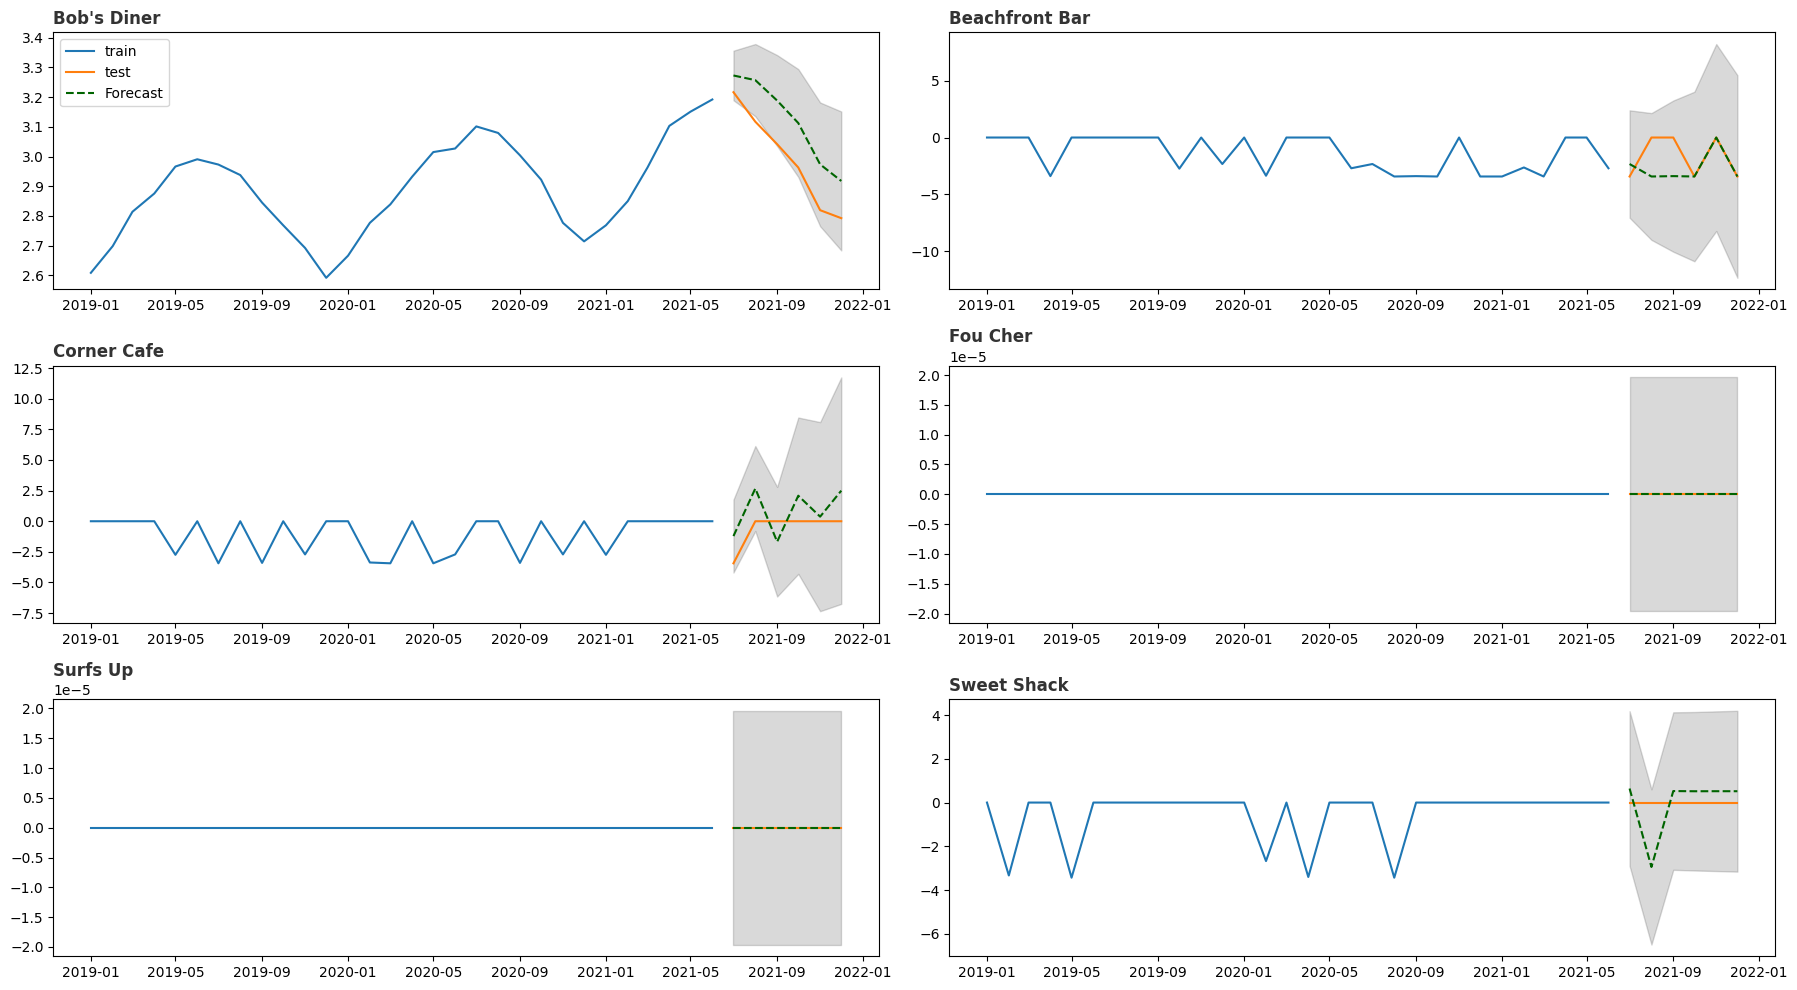

In [260]:
# Model building and evaluation for each store

import pmdarima as pm

# Creating a figure
fig, axs = plt.subplots(3,2, figsize=(18, 10))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Adding subplots in a loop
for i, store in enumerate(store_list):
    start_time = time.time()
    train_plt = train[train['store_id'] == i+1]['item_count']
    test_plt  = test[test['store_id'] == i+1]['item_count']

    SARIMA_model =  pm.auto_arima(train_plt,
                              start_p = 1,
                              start_P = 0,
                              start_q = 3,
                              max_p = 3,
                              max_q = 5,
                              test = 'adf',
                              m = 12, # freq of seasonality: once every 12 months
                              seasonal = True,
                              d = None, # let model find differencing param
                              D = 1, # order of seasonal differencing
                              trace = False, # logs
                              error_action = 'ignore', # silence errors
                              supress_warnings = True,
                              stepwise = True,
                              )
    test_pred, lower_band_plt, upper_band_plt = forecast_sarima(SARIMA_model, 6)
    runtime = time.time() - start_time

    # Compute metrics
    rmse = round(np.sqrt(mean_squared_error(test_plt, test_pred)),3)

    metrics=[]
    metrics.append(
        {
            'Store': store,
            'Algorithm': 'SARIMA',
            'Root Mean Squared Error': rmse,
            'Runtime (in secs)': runtime
        }
    )
    metrics_df = pd.DataFrame(metrics)

    model_comparison = pd.concat([model_comparison, metrics_df], axis=0)

    axs[i].plot(train_plt, label='train')
    axs[i].plot(test_plt, label='test')
    axs[i].plot(test_pred, linestyle='--', color='darkgreen', label = 'Forecast')
    axs[i].fill_between(lower_band_plt.index, lower_band_plt, upper_band_plt, color='k', alpha=0.15)
    axs[i].set_title(store, loc='left', fontweight='bold', color='#333333')
    axs[0].legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [261]:
model_comparison=model_comparison.sort_values('Store')
model_comparison

Store         Algorithm  Root Mean Squared Error  \
0  Beachfront Bar  LinearRegression                    0.039   
0  Beachfront Bar      RandomForest                    0.030   
0  Beachfront Bar           XGBoost                    0.023   
0  Beachfront Bar            SARIMA                    2.024   
0     Bob's Diner  LinearRegression                    3.450   
0     Bob's Diner      RandomForest                    1.149   
0     Bob's Diner           XGBoost                    1.821   
0     Bob's Diner            SARIMA                    0.133   
0     Corner Cafe  LinearRegression                    0.019   
0     Corner Cafe      RandomForest                    0.022   
0     Corner Cafe           XGBoost                    0.028   
0     Corner Cafe            SARIMA                    2.065   
0        Fou Cher            SARIMA                    0.000   
0        Fou Cher           XGBoost                    0.000   
0        Fou Cher      RandomForest                    0.000   
0        Fou Cher  LinearRegression                    0.000   
0        Surfs Up           XGBoost                    0.000   
0        Surfs Up  LinearRegression                    0.000   
0        Surfs Up            SARIMA                    0.000   
0        Surfs Up      RandomForest                    0.000   
0     Sweet Shack  LinearRegression                    0.007   
0     Sweet Shack      RandomForest                    0.004   
0     Sweet Shack           XGBoost                    0.002   
0     Sweet Shack            SARIMA                    1.301   

   Runtime (in secs)  
0           0.042825  
0           1.610173  
0           0.137608  
0           4.231126  
0           0.009614  
0           1.774468  
0           2.799378  
0          13.243634  
0           0.004484  
0           1.123541  
0           0.129682  
0          28.520054  
0           0.040050  
0           0.133886  
0           1.128829  
0           0.006117  
0           0.138709  
0           0.004126  
0           0.036910  
0           1.132962  
0           0.004008  
0           1.106282  
0           0.133504  
0           6.245150

##### **Model Diagnostics**

Model is a good fit based on the following conditions:

1) Standardized residual
- There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.

2) Histogram plus KDE estimate
- The KDE curve should be very similar to the normal distribution N(0,1)

3) Normal Q-Q
- Most of the data points should lie on the straight line

4) Correlogram (ACF plot)
- 95% of correlations for lag greater than zero should not be significant.
- The grey area is the confidence band, and if values fall outside of this then they are statistically significant. We want all values inside this area.

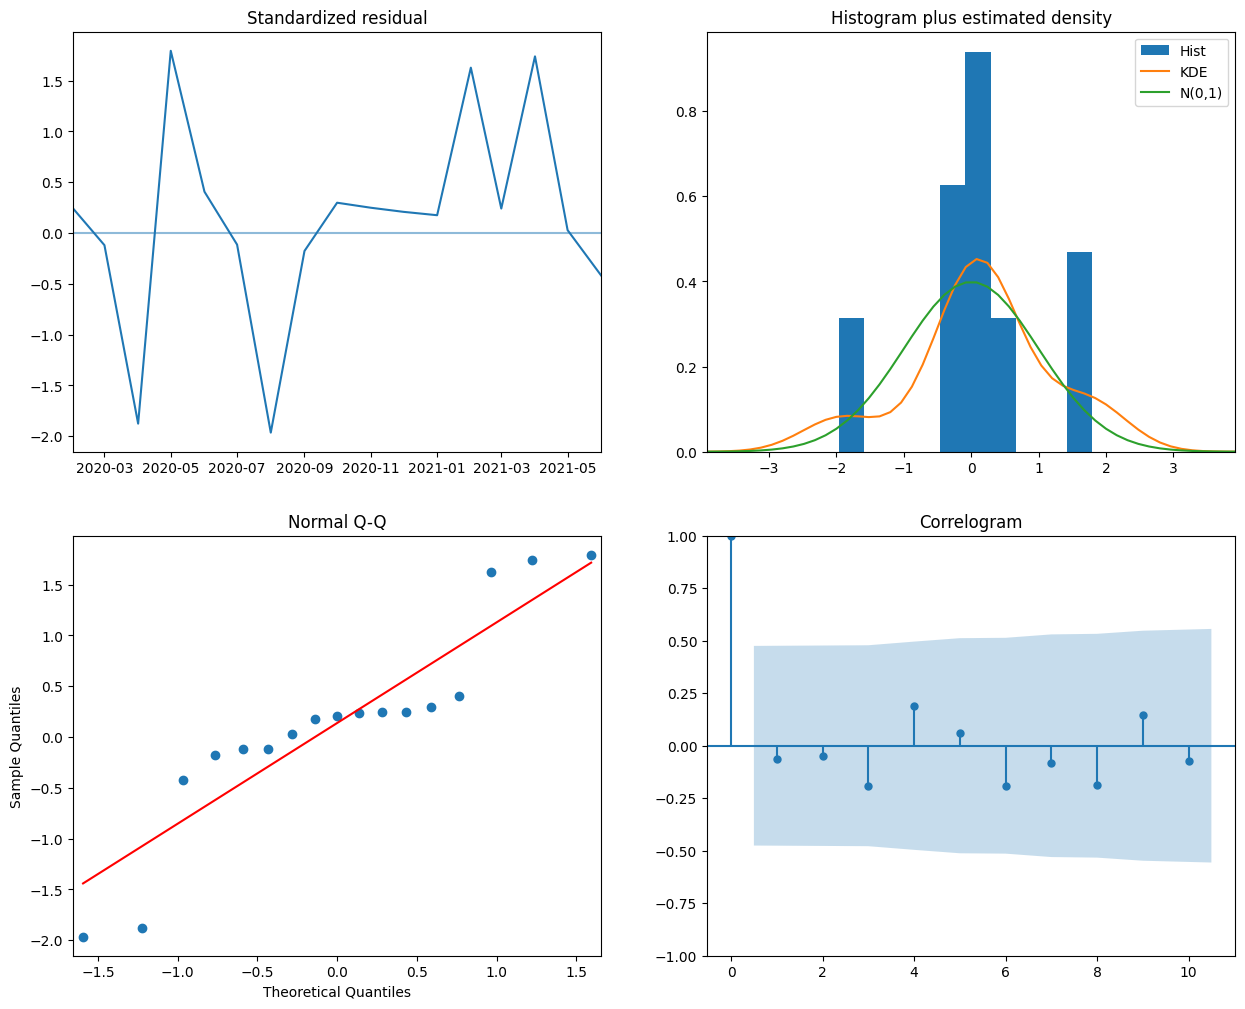

In [262]:
SARIMA_model.plot_diagnostics(figsize = (15,12))
plt.show()

Observations:
****
1) Standardized residual
- It is quite consistent across the graph.

2) Histogram plus KDE estimate
- The KDE curve is similar to the normal distribution.

3) Normal Q-Q
- The data points are clustered close to the straight line

4) Correlogram (ACF plot)
- All values inside this the 95% confidence interval.

#### **Facebook's Prophet**

In [268]:
# Prepare the dataset

fc1_data = sales_merged[['date', 'store_id', 'sales']]

# create store-wise daily aggregates
fc_agg = pd.DataFrame(round(fc1_data.groupby(['store_id','date'])['sales'].mean())).reset_index()
fc_agg.rename(columns={'date':'ds', 'sales':'y'}, inplace=True)
fc_agg = fc_agg.set_index(['store_id','ds'])
fc_agg.sort_index(inplace=True) # sort dates
fc_agg.reset_index(inplace=True)
fc_agg.head()


store_id         ds      y
0         1 2019-01-01  165.0
1         1 2019-01-02  123.0
2         1 2019-01-03  163.0
3         1 2019-01-04  206.0
4         1 2019-01-05  202.0

In [269]:
# Splitting data into train and test. We will take the last 6 months as test data
split_date = '2021-07-01'
train = fc_agg[fc_agg.ds < split_date]
test  = fc_agg[fc_agg.ds >= split_date]
train.head()

store_id         ds      y
0         1 2019-01-01  165.0
1         1 2019-01-02  123.0
2         1 2019-01-03  163.0
3         1 2019-01-04  206.0
4         1 2019-01-05  202.0

In [169]:
test.tail()

store_id         ds    y
6571         6 2021-12-27  1.0
6572         6 2021-12-28  3.0
6573         6 2021-12-29  0.0
6574         6 2021-12-30  0.0
6575         6 2021-12-31  2.0

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxw5m34nc/otrj1b4_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxw5m34nc/7jz0n6o_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90863', 'data', 'file=/tmp/tmpxw5m34nc/otrj1b4_.json', 'init=/tmp/tmpxw5m34nc/7jz0n6o_.json', 'output', 'file=/tmp/tmpxw5m34nc/prophet_modelmbnginsv/prophet_model-20240628052554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:25:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:25:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxw5m34nc/_5puq79_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxw5m34nc/xlwcebi1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

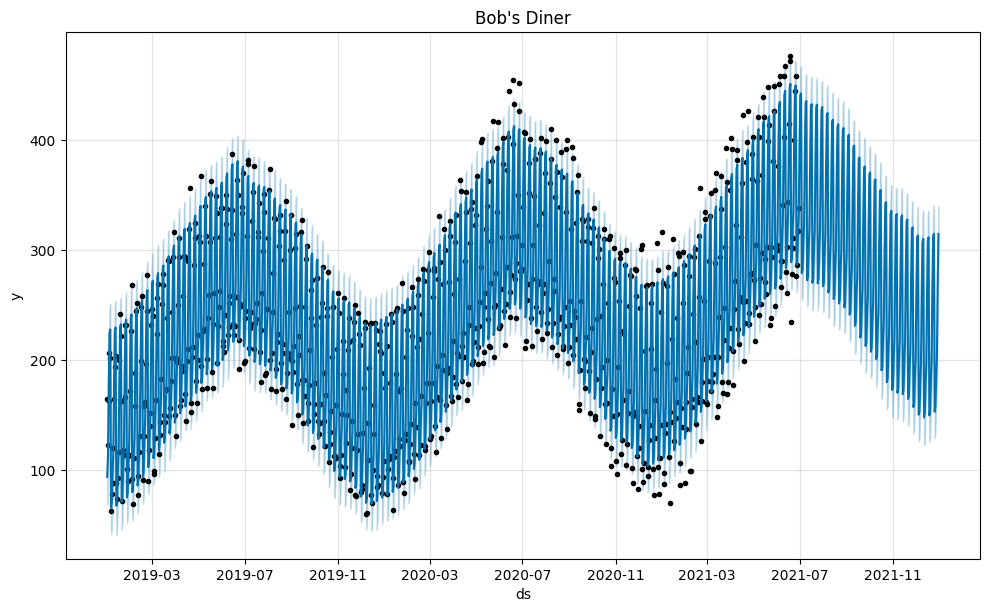

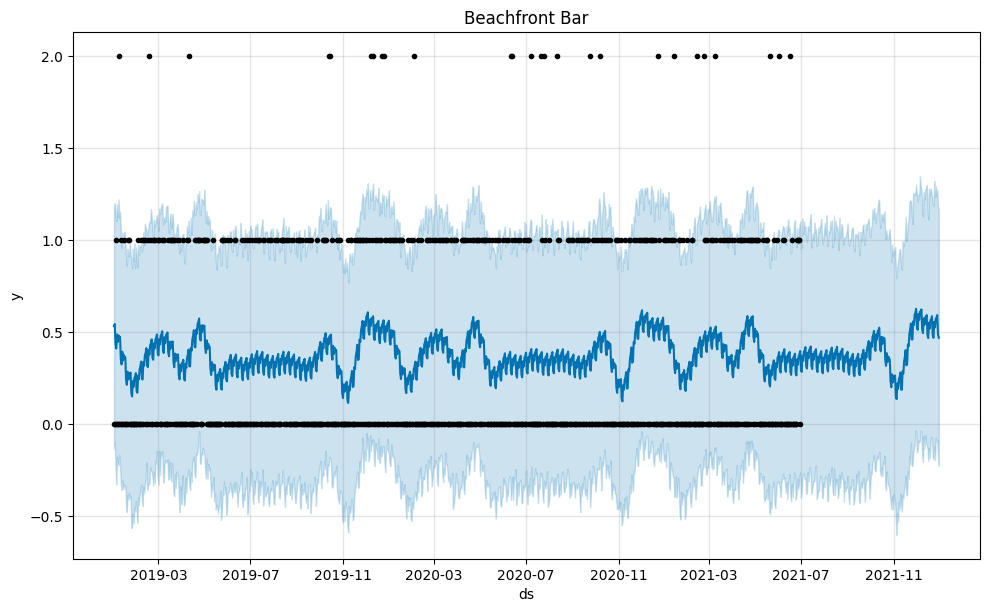

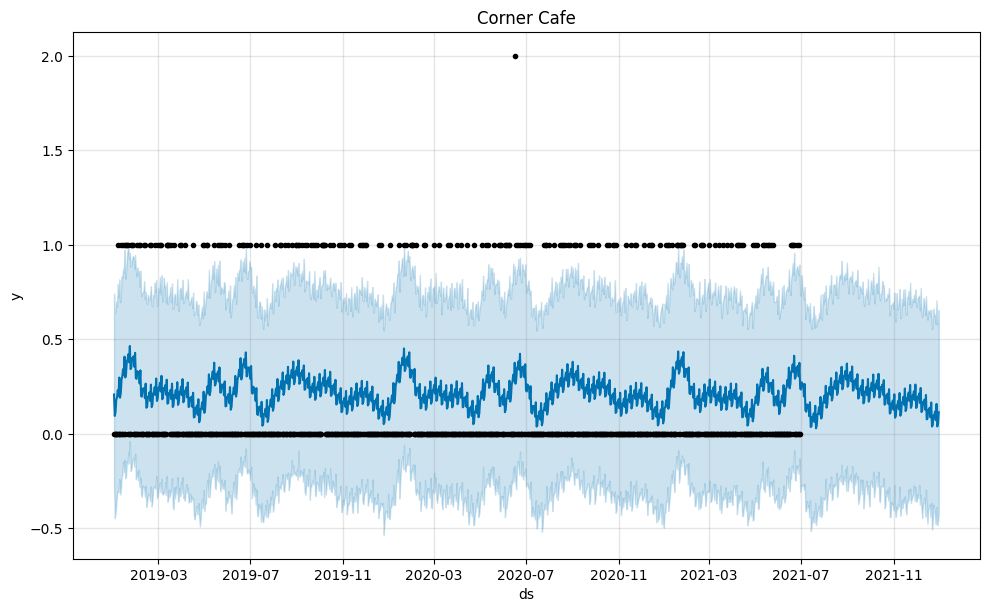

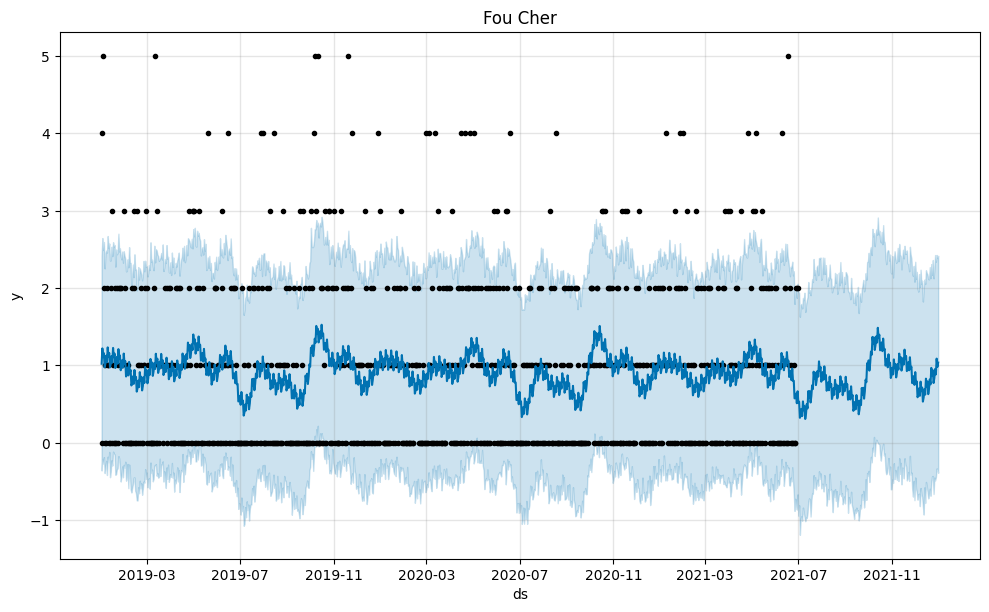

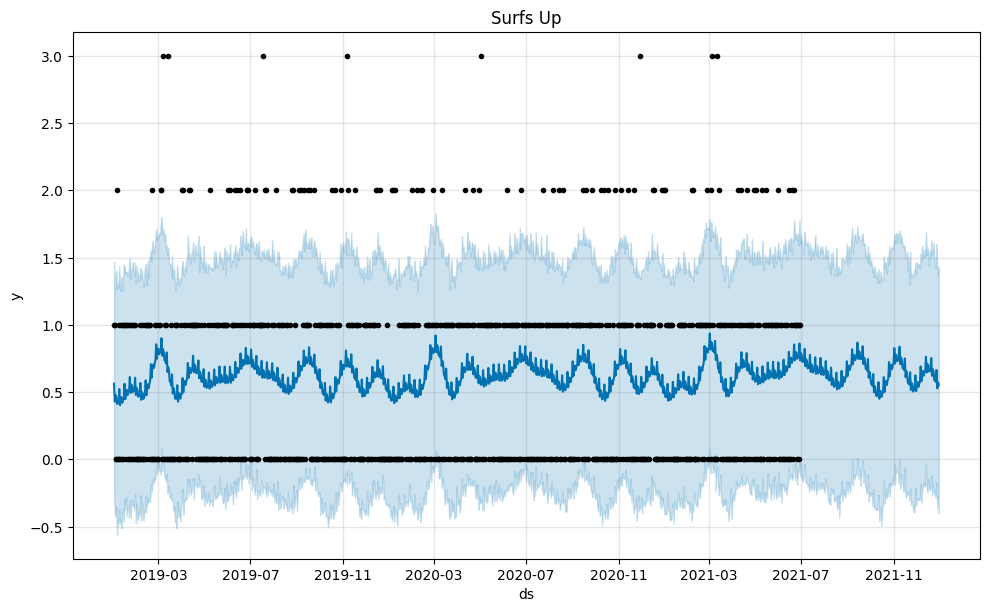

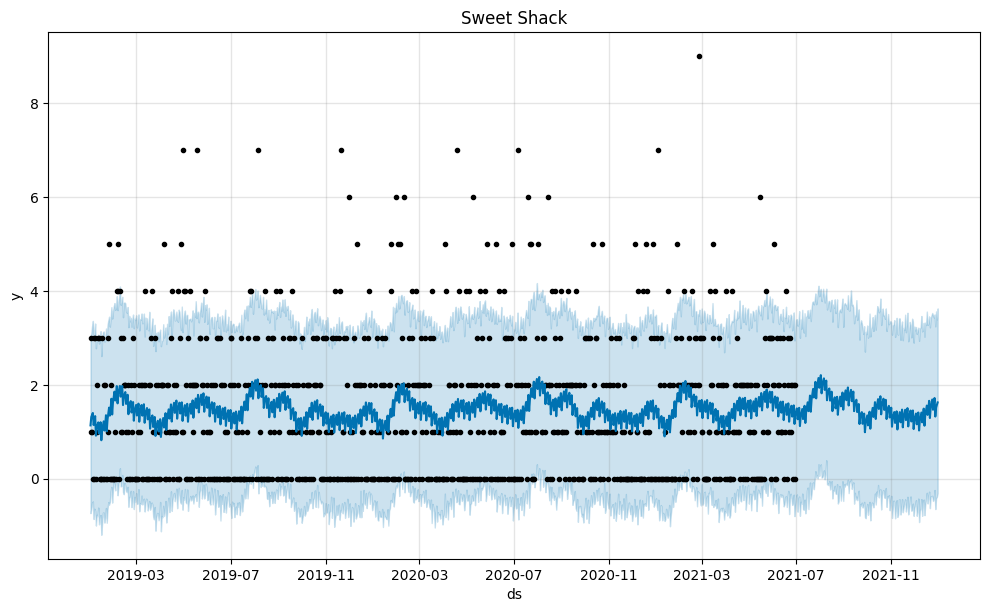

In [295]:
# Train and predict using Prophet

metrics=[]
pred_df=pd.DataFrame()
for i, store in enumerate(store_list):
  store_train = train[train.store_id == i+1][['ds','y']]
  # creating test df with only dates
  test_fc = m.make_future_dataframe(periods=184) # 6 months of test data
  pred=[]

  start_time = time.time()
  # Instantiate the Prophet class
  m = Prophet()

  # Fit the model
  m.fit(store_train)

  # Predict
  test_pred = m.predict(test_fc)
  test_pred['store'] = store
  pred_df = pd.concat([pred_df, test_pred], axis=0)
  runtime = time.time() - start_time

  # Evaluate
  actual = test[test['store_id'] == i+1]['y']
  predicted = test_pred[test_pred.ds >= split_date]['yhat']
  rmse = np.sqrt(mean_squared_error(actual, predicted))


  metrics.append({'Store': store,
                           'Algorithm': 'Prophet',
                           'Root Mean Squared Error': rmse,
                           'Runtime (in secs)': runtime
                           })

  # Plot
  fig1 = m.plot(test_pred)
  plt.title(store)



metrics_df = pd.DataFrame(metrics)
model_comparison = pd.concat([model_comparison, metrics_df], axis=0).sort_values('Store')

Bob's Diner


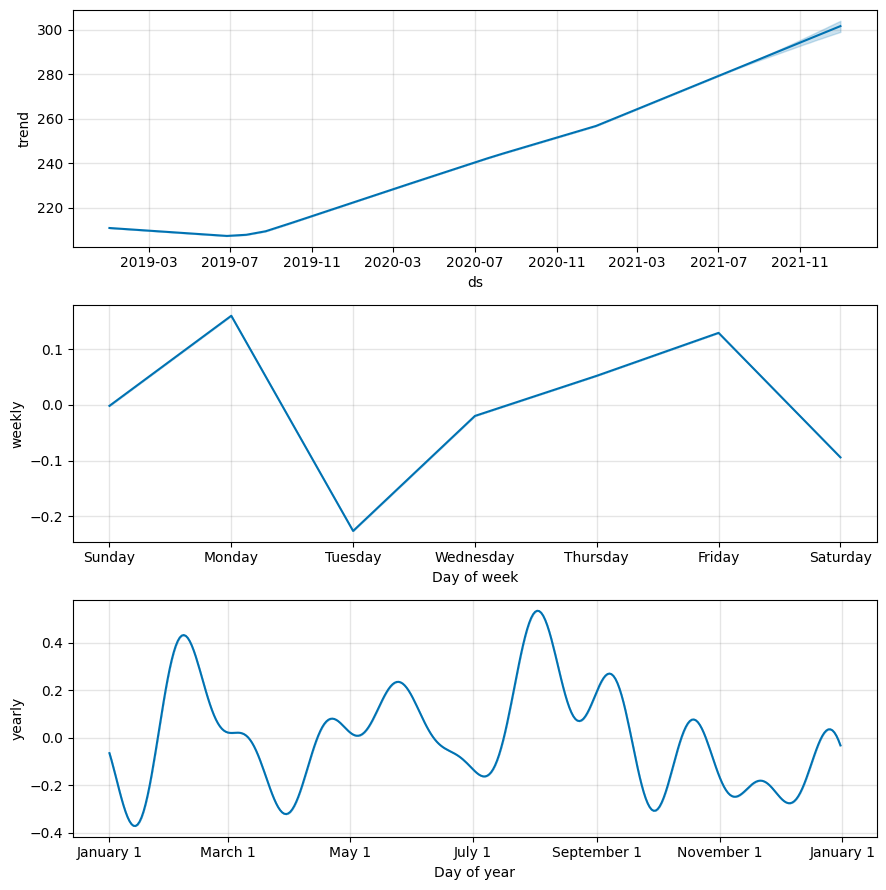

Beachfront Bar


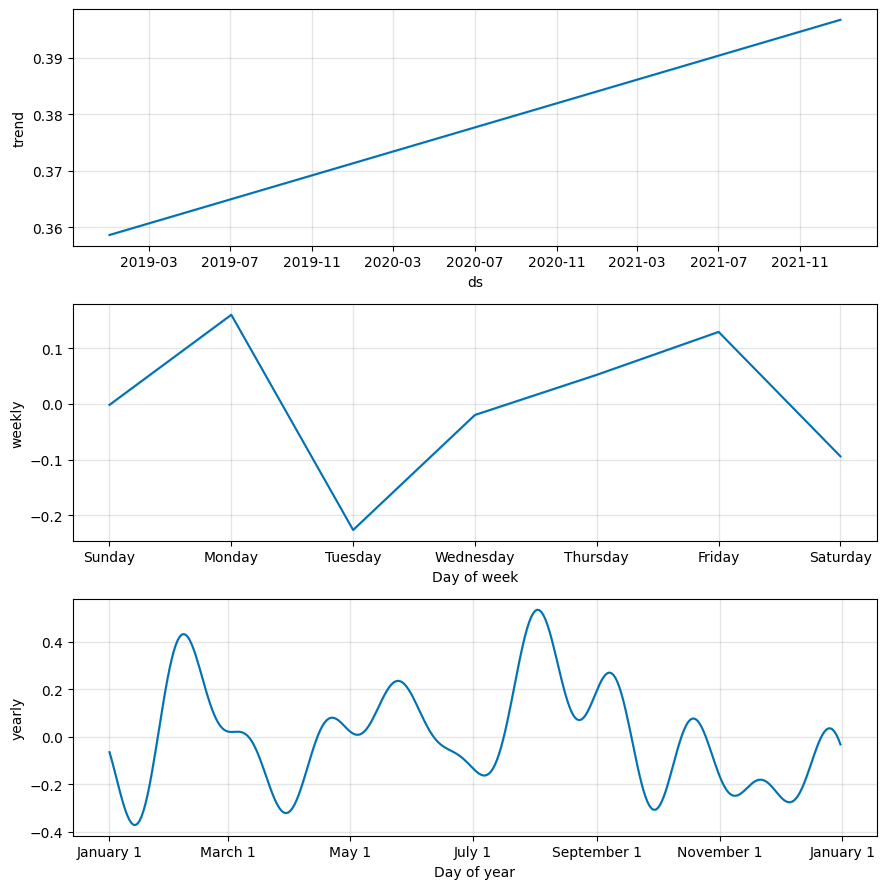

Corner Cafe


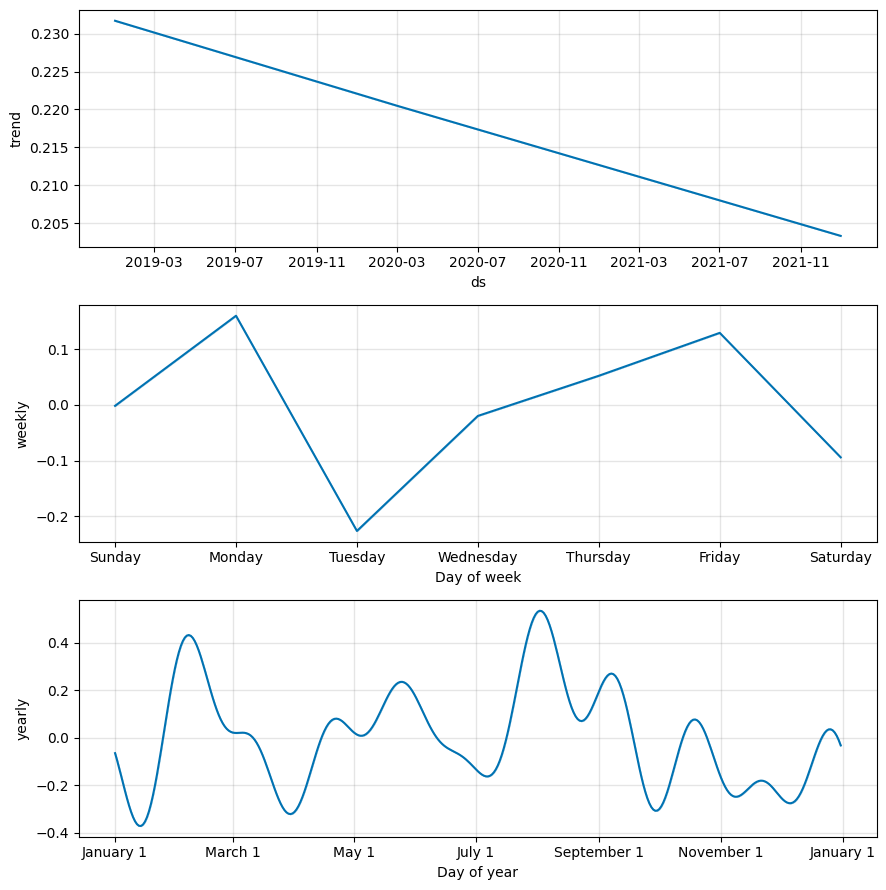

Fou Cher


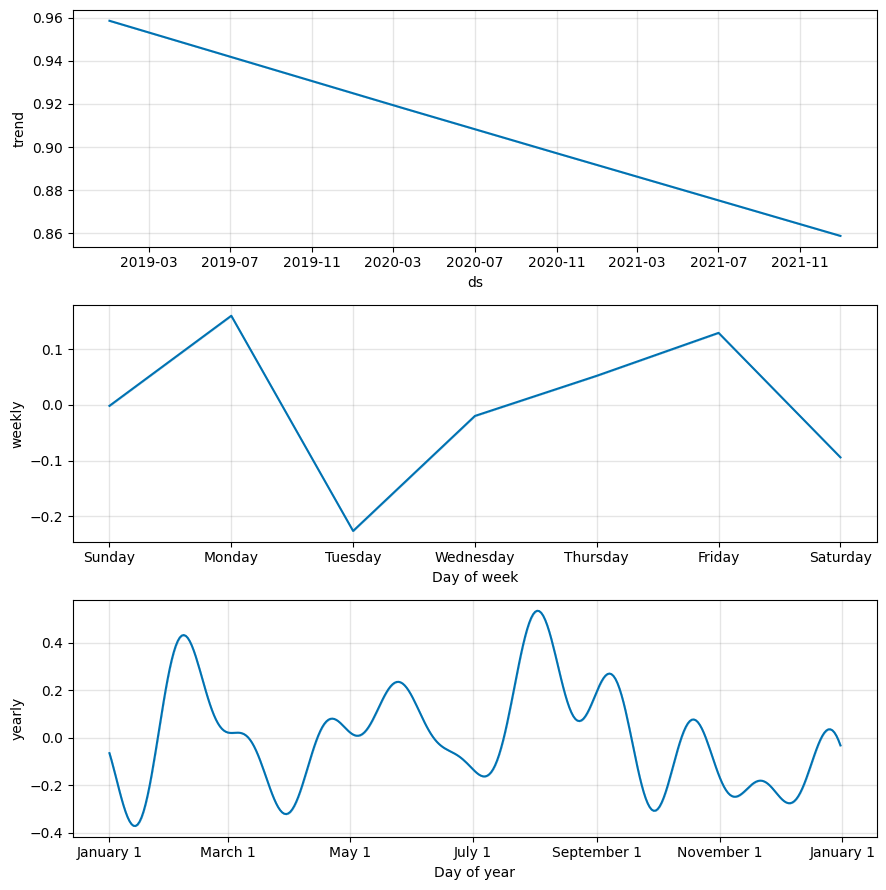

Surfs Up


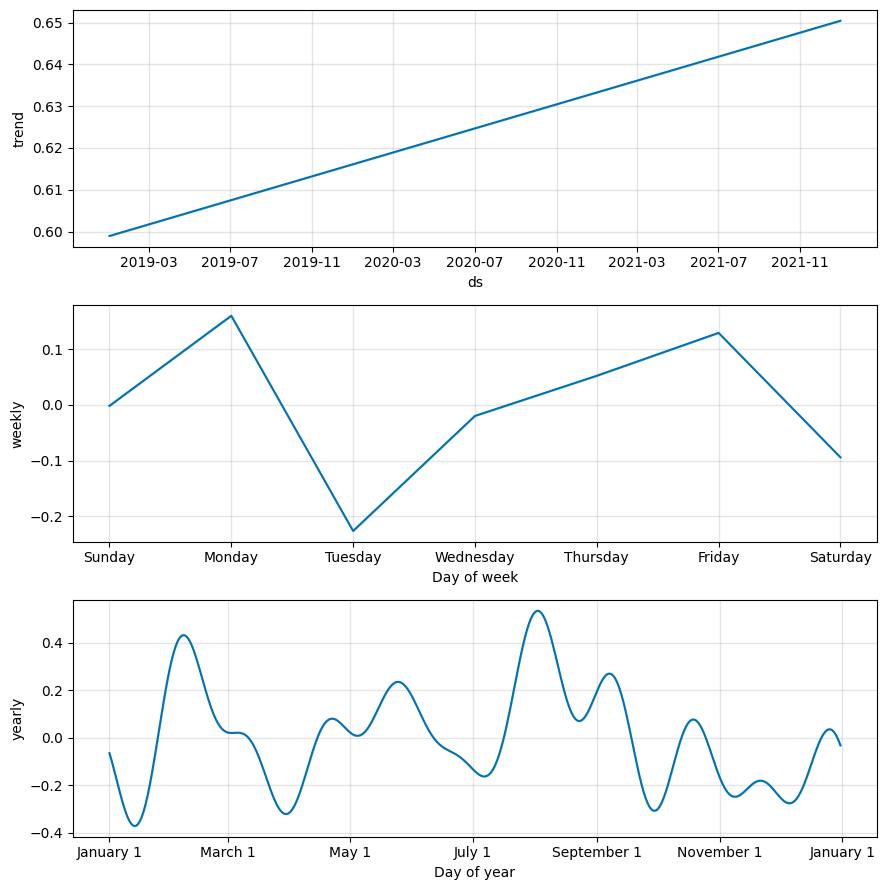

Sweet Shack


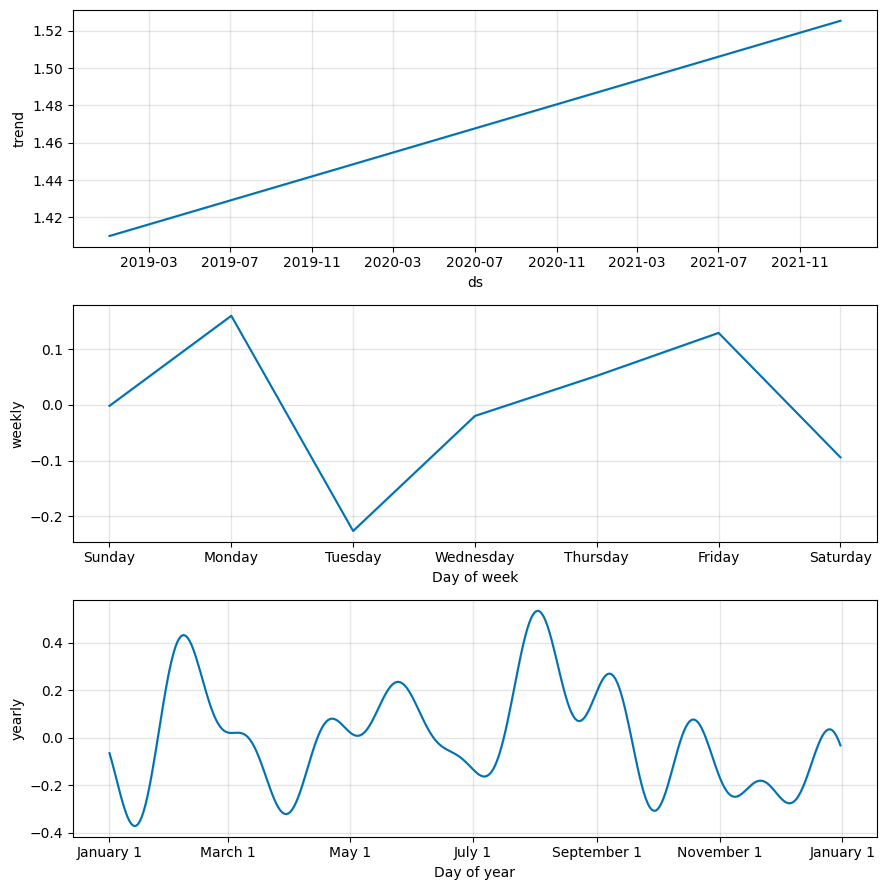

In [309]:
# Plot store-wise trends

for i, store in enumerate(store_list):
  print(store)
  pred = pred_df[pred_df.store == store].drop('store', axis=1)
  fig2 = m.plot_components(pred)

In [296]:
model_comparison

Store         Algorithm  Root Mean Squared Error  \
0  Beachfront Bar  LinearRegression                 0.039000   
0  Beachfront Bar      RandomForest                 0.030000   
0  Beachfront Bar           XGBoost                 0.023000   
0  Beachfront Bar            SARIMA                 2.024000   
1  Beachfront Bar           Prophet                 0.508142   
0     Bob's Diner  LinearRegression                 3.450000   
0     Bob's Diner      RandomForest                 1.149000   
0     Bob's Diner           XGBoost                 1.821000   
0     Bob's Diner            SARIMA                 0.133000   
0     Bob's Diner           Prophet                34.248791   
0     Corner Cafe  LinearRegression                 0.019000   
0     Corner Cafe      RandomForest                 0.022000   
0     Corner Cafe           XGBoost                 0.028000   
0     Corner Cafe            SARIMA                 2.065000   
2     Corner Cafe           Prophet                 0.447118   
3        Fou Cher           Prophet                 1.069466   
0        Fou Cher      RandomForest                 0.000000   
0        Fou Cher  LinearRegression                 0.000000   
0        Fou Cher           XGBoost                 0.000000   
0        Fou Cher            SARIMA                 0.000000   
0        Surfs Up  LinearRegression                 0.000000   
0        Surfs Up            SARIMA                 0.000000   
0        Surfs Up      RandomForest                 0.000000   
4        Surfs Up           Prophet                 0.861536   
0        Surfs Up           XGBoost                 0.000000   
0     Sweet Shack  LinearRegression                 0.007000   
0     Sweet Shack      RandomForest                 0.004000   
0     Sweet Shack           XGBoost                 0.002000   
0     Sweet Shack            SARIMA                 1.301000   
5     Sweet Shack           Prophet                 1.406550   

   Runtime (in secs)  
0           0.042825  
0           1.610173  
0           0.137608  
0           4.231126  
1           0.732511  
0           0.009614  
0           1.774468  
0           2.799378  
0          13.243634  
0           0.746303  
0           0.004484  
0           1.123541  
0           0.129682  
0          28.520054  
2           0.596837  
3           0.616112  
0           1.128829  
0           0.006117  
0           0.133886  
0           0.040050  
0           0.004126  
0           0.036910  
0           1.132962  
4           0.705635  
0           0.138709  
0           0.004008  
0           1.106282  
0           0.133504  
0           6.245150  
5           1.042681

Observations:
****
From the RMSE scores, we see that Random Forest performs consistently well across all the stores. Hence we will use Random Forest Classifier algorithm to make a forecast for the next year.

#### **Forecasting for next year**

**Create the dataset**

In [263]:
# Creating the dataset to make a forecast for the next year 2022

date_list = pd.date_range('2022-01-01','2022-12-31')
forecast_2022 = pd.DataFrame(date_list, columns=['date'])
forecast_2022 = forecast_2022.resample('M', on='date').min().reset_index() #aggregate by month to get 1 date per month


# create the time series features for this dataset
forecast_2022 = create_ts_features(forecast_2022)
forecast_2022_ind = forecast_2022.set_index('date')
forecast_2022_ind.head()

year  quarter  month  day  dayofyear  dayofweek
date                                                       
2022-01-31  2022        1      1   31         31          0
2022-02-28  2022        1      2   28         59          0
2022-03-31  2022        1      3   31         90          3
2022-04-30  2022        2      4   30        120          5
2022-05-31  2022        2      5   31        151          1

**Build the model**

In [264]:
# make predictions for next year

rfc_model = RandomForestRegressor(n_estimators = 1000, max_depth=5, random_state=123, min_samples_split=5)

forecast = pd.DataFrame()
df_fc  = pd.DataFrame()
df_test = pd.DataFrame()
for i, store_name in enumerate(store_list):
  store = fc1_agg[fc1_agg['store_id']==i+1].drop('store_id', axis=1)

   # Splitting data into train and test. We will take the last 6 months as test data
  split_date = '2021-07-01'
  train = store.loc[store.index < split_date].copy()
  test  = store.loc[store.index >= split_date].copy()

  # split the train and test datasets into X and y variables
  X_train, y_train = train.drop('item_count', axis=1), train['item_count']
  X_test, y_test = test.drop('item_count', axis=1), test['item_count']


  # Fit
  rfc_model.fit(X_train, y_train)
  # Prdict
  test['store_id'] = i+1
  test['y_test_pred'] = rfc_model.predict(X_test)
  df_test = pd.concat([test, df_test], axis=0)


  # Forecast
  y_test_fc = pd.DataFrame({
        'Store id' : i+1,
        'Store name': store_name,
        'Item count forecast': rfc_model.predict(forecast_2022_ind)
        })


  # Prepare result
  df_fc = pd.concat([forecast_2022, y_test_fc], axis=1)
  forecast = pd.concat([forecast, df_fc], axis=0)

forecast.date = pd.to_datetime(forecast.date)
forecast = forecast.set_index('date')

**Visualize sales volume and forecast for next year**



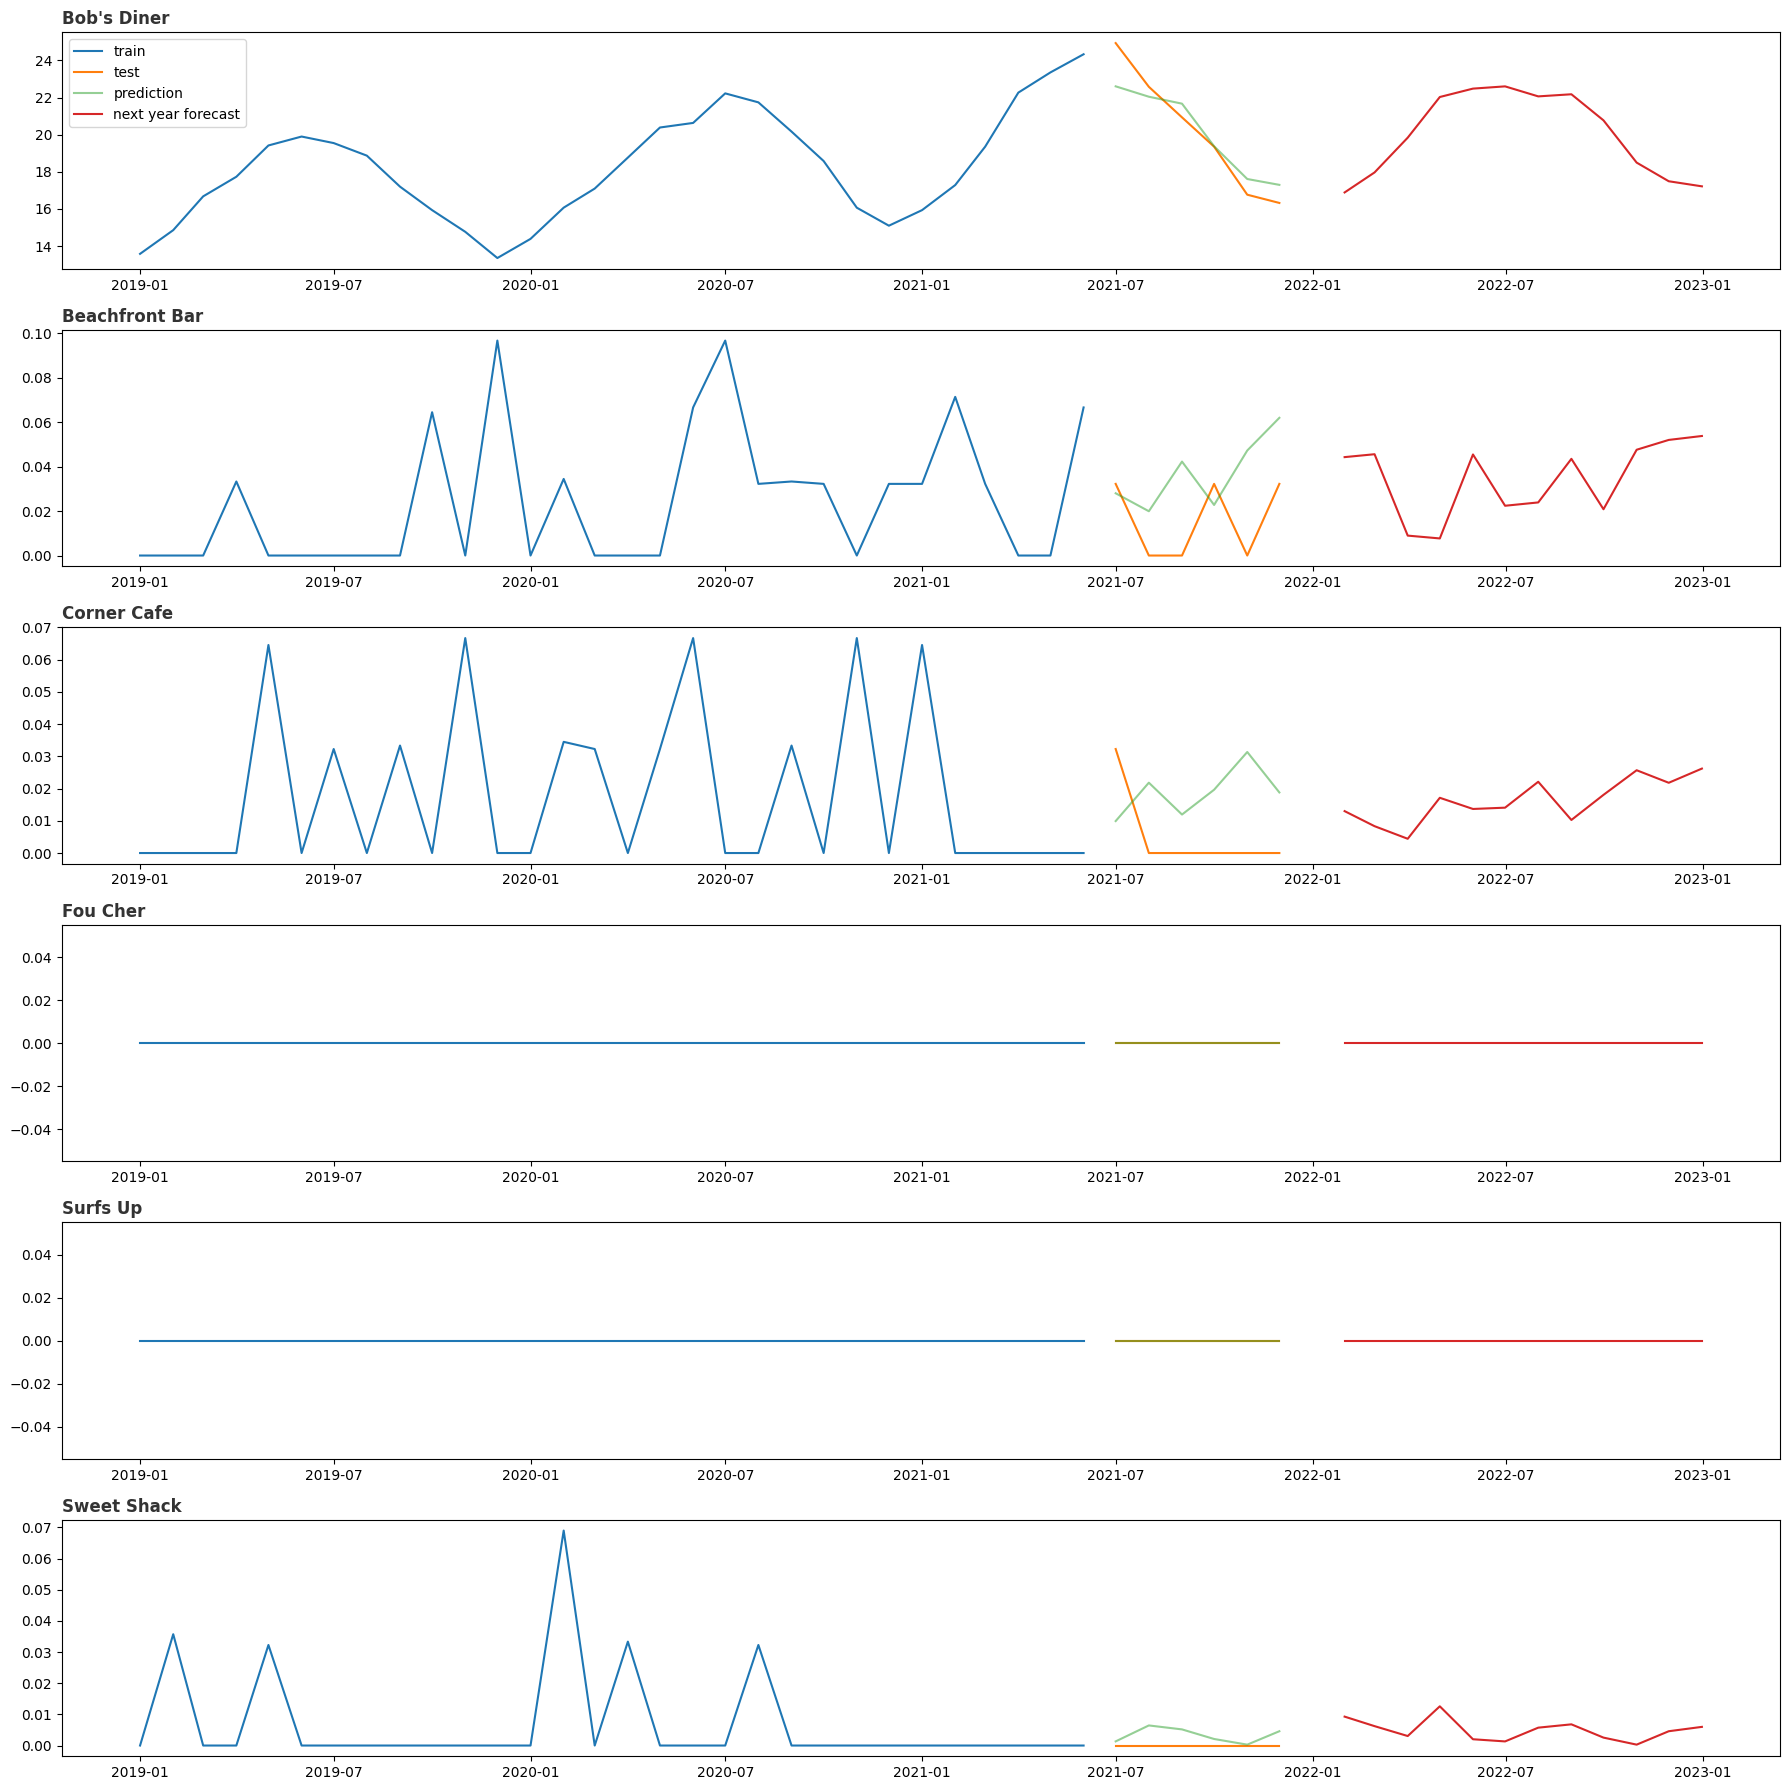

In [265]:
# Creating a figure
fig, axs = plt.subplots(6, 1, figsize=(18, 18))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Adding subplots in a loop
for i, store in enumerate(store_list):

    train_plt = fc1_agg[(fc1_agg.index < split_date) & (fc1_agg.store_id == i+1)]
    test_plt = df_test[df_test['store_id'] == i+1]
    fc_plt = forecast[forecast['Store id'] == i+1]

    axs[i].plot(train_plt.index, train_plt.item_count, label='train')
    axs[i].plot(test_plt.index, test_plt.item_count, label='test')
    axs[i].plot(test_plt.index, test_plt.y_test_pred, label='prediction', alpha=0.5)
    axs[i].plot(fc_plt.index, fc_plt['Item count forecast'], label='next year forecast')
    axs[i].set_title(store, loc='left', fontweight='bold', color='#333333')
    axs[0].legend(loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## **Forecasting using deep learning algorithms**

In [65]:
fc1_data = sales_merged[['date', 'store_id', 'sales']]

# create daily aggregates across all stores
fc_agg = pd.DataFrame(round(fc1_data.groupby(['date'])['sales'].mean())).reset_index()
fc_agg = fc_agg.set_index(['date'])
fc_agg.sort_index(inplace=True) # sort dates
fc_agg.head()

# # Uncomment below code to create store-wise daily aggregates
# fc_agg = pd.DataFrame(round(fc1_data.groupby(['date', 'store_id'])['sales'].mean())).reset_index()
# fc_agg = fc_agg.set_index(['store_id','date'])
# fc_agg.sort_index(inplace=True) # sort dates
# fc_agg.head()


sales
date             
2019-01-01   40.0
2019-01-02   31.0
2019-01-03   41.0
2019-01-04   50.0
2019-01-05   49.0

In [66]:
# Scaling the data
from sklearn.preprocessing import MinMaxScaler

fc1_agg = fc_agg.copy()

# Instantiate
scaler = MinMaxScaler(feature_range=(-1,1))
# Fit-Transform
scaled = scaler.fit_transform(fc1_agg)

# Update dataframe
fc1_agg['sales'] = scaled
fc1_agg.reset_index(inplace=True)
fc1_agg.set_index('date', inplace=True)
fc1_agg.head()

sales
date                
2019-01-01 -0.509804
2019-01-02 -0.686275
2019-01-03 -0.490196
2019-01-04 -0.313725
2019-01-05 -0.333333

### **Define the train and test series**

In [67]:
# Splitting data into train and test. We will take the last 6 months as test data
split_date1 = '2021-04-01'
split_date2 = '2021-07-01'
train = fc1_agg.loc[fc1_agg.index < split_date1].copy()
val = fc1_agg.loc[(fc1_agg.index >= split_date1) & (fc1_agg.index < split_date2)].copy()
test  = fc1_agg.loc[fc1_agg.index >= split_date2].copy()

print('Train data range: ', min(train.index) ,'-', max(train.index))
print('Validation data range: ', min(val.index) ,'-', max(val.index))
print('Test data range : ', min(test.index) ,'-', max(test.index))


Train data range:  2019-01-01 00:00:00 - 2021-03-31 00:00:00
Validation data range:  2021-04-01 00:00:00 - 2021-06-30 00:00:00
Test data range :  2021-07-01 00:00:00 - 2021-12-31 00:00:00


### **Create the lag dataset**


This involves creating X (features) and y (label).
X is a sequence of prior timesteps causing the next timestep y. We choose the lag. eg 5

| X | Y |
| ----- | ----- |
| [  [1]  [2]  [3]  [4]  [5] ] | [6] |
| [  [2]  [3]  [4]  [5]  [6] ] | [7] |
| [  [3]  [4]  [5]  [6]  [7] ] | [8] |

In [68]:
# Define a function to create the lag data
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np) - window_size):
    row = [ [a] for a in df_as_np[i:i+window_size]]
    X.append(row)

    label = df_as_np[i+window_size]
    y.append(label)

  return np.array(X), np.array(y)

In [69]:
# Uncomment below code for store-wise analysis
# train = train[train.store_id == 1]['sales']
# val   = val[val.store_id == 1]['sales']
# test  = test[test.store_id == 1]['sales']


WINDOW_SIZE = 5

X_train, y_train = df_to_X_y(train, WINDOW_SIZE)
X_val, y_val   = df_to_X_y(val, WINDOW_SIZE)
X_test, y_test   = df_to_X_y(test, WINDOW_SIZE)

print('X_train, y_train: ', X_train.shape, y_train.shape)
print('X_val, y_val: ', X_val.shape, y_val.shape)
print('X_test, y_test: ', X_test.shape, y_test.shape)

X_train, y_train:  (816, 5, 1, 1) (816, 1)
X_val, y_val:  (86, 5, 1, 1) (86, 1)
X_test, y_test:  (179, 5, 1, 1) (179, 1)


### **Generate synthetic data for the last 12 months**

In [70]:
# Synthetic data generation

def generate_synthetic_data(data, days=365):
    synthetic_data = data.sample(n=days, replace=True).reset_index()
    synthetic_data.drop(columns=['index', 'date'], inplace=True)
    synthetic_data['date'] = pd.date_range(start='2021-01-01', periods=days, freq='D')
    return synthetic_data

synthetic_data = generate_synthetic_data(sales_merged_no_outliers, 365)
# Create time series features
create_ts_features(synthetic_data)
synthetic_data = synthetic_data[['date', 'year',	'quarter', 'month',	'day', 'dayofyear', 'dayofweek',	'store_id',	'store_name', 'item_id', 'item_name', 'kcal', 'price', 'item_count', 'sales']]
synthetic_data

date  year  quarter  month  day  dayofyear  dayofweek  store_id  \
0   2021-01-01  2021        1      1    1          1          4         1   
1   2021-01-02  2021        1      1    2          2          5         4   
2   2021-01-03  2021        1      1    3          3          6         5   
3   2021-01-04  2021        1      1    4          4          0         4   
4   2021-01-05  2021        1      1    5          5          1         5   
..         ...   ...      ...    ...  ...        ...        ...       ...   
360 2021-12-27  2021        4     12   27        361          0         4   
361 2021-12-28  2021        4     12   28        362          1         1   
362 2021-12-29  2021        4     12   29        363          2         4   
363 2021-12-30  2021        4     12   30        364          3         3   
364 2021-12-31  2021        4     12   31        365          4         4   

      store_name  item_id                          item_name  kcal  price  \
0    Bob's Diner       19                 Strawberry Smoothy   145   2.89   
1       Fou Cher       34                  Sweet Savory Cake   721  27.47   
2    Corner Cafe       63              Frozen Chocolate Cake   519   3.74   
3       Fou Cher       82                            Martini   556   5.45   
4    Corner Cafe       50                         Pike Lunch   653  26.37   
..           ...      ...                                ...   ...    ...   
360     Fou Cher        2  Breaded Fish with Vegetables Meal   772  15.09   
361  Bob's Diner       67                    Sweet Lamb Cake   558   7.00   
362     Fou Cher       34                  Sweet Savory Cake   721  27.47   
363  Sweet Shack       30                     Fantastic Cake   525   5.08   
364     Fou Cher       82                            Martini   556   5.45   

     item_count   sales  
0          96.0  381.48  
1           0.0    0.00  
2           0.0    0.00  
3           0.0    0.00  
4           0.0    0.00  
..          ...     ...  
360         0.0    0.00  
361        10.0   70.00  
362         0.0    0.00  
363         0.0    0.00  
364         0.0    0.00  

[365 rows x 15 columns]

### **Build the LSTM model**

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanAbsolutePercentageError, MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError


model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:
# Saving the best model
cp = ModelCheckpoint('/content/drive/MyDrive/SalesForecasting_Datasets/model/', save_best_only=True)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train, y_train,
          validation_data = (X_val, y_val),
          epochs = 50,
          callbacks = [cp]
          )

Epoch 1/50
26/26 [==============================] - 14s 366ms/step - loss: 0.1554 - val_loss: 0.2784
Epoch 2/50
26/26 [==============================] - 8s 323ms/step - loss: 0.1472 - val_loss: 0.2705
Epoch 3/50
26/26 [==============================] - 9s 342ms/step - loss: 0.1434 - val_loss: 0.2653
Epoch 4/50
26/26 [==============================] - 8s 313ms/step - loss: 0.1373 - val_loss: 0.2509
Epoch 5/50
26/26 [==============================] - 8s 323ms/step - loss: 0.1281 - val_loss: 0.2340
Epoch 6/50
26/26 [==============================] - 8s 305ms/step - loss: 0.1122 - val_loss: 0.2066
Epoch 7/50
26/26 [==============================] - 8s 335ms/step - loss: 0.0927 - val_loss: 0.1662
Epoch 8/50
26/26 [==============================] - 8s 324ms/step - loss: 0.0843 - val_loss: 0.1429
Epoch 9/50
26/26 [==============================] - 8s 315ms/step - loss: 0.0794 - val_loss: 0.1417
Epoch 10/50
26/26 [==============================] - 9s 348ms/step - loss: 0.0765 - val_loss: 0.131

In [73]:
# loading the best saved model into memory

from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/SalesForecasting_Datasets/model/')

### **Make predictions**

In [74]:
y_train_pred = model.predict(X_train)
y_val_pred   = model.predict(X_val)
y_test_pred  = model.predict(X_test)
print(y_train_pred.shape)

6/6 [==============================] - 0s 5ms/step
(816, 1)


In [75]:
# create dataframe with actuals and predictions
train_act = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
train_pred = scaler.inverse_transform(y_train_pred).flatten()

val_act  = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
val_pred = scaler.inverse_transform(y_val_pred).flatten()

test_act  = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
test_pred = scaler.inverse_transform(y_test_pred).flatten()

train_df = pd.DataFrame(data = {'Dataset':'Train','Actuals': train_act, 'Predicted': train_pred})
val_df = pd.DataFrame(data = {'Dataset':'Validation','Actuals': val_act, 'Predicted': val_pred})
test_df = pd.DataFrame(data = {'Dataset':'Test','Actuals': test_act, 'Predicted': test_pred})

train_results = pd.concat([train_df, val_df, test_df], axis = 0)
train_results

Dataset  Actuals  Predicted
0     Train     16.0  51.915676
1     Train     19.0  24.979496
2     Train     22.0  28.201834
3     Train     29.0  35.202896
4     Train     40.0  47.561543
..      ...      ...        ...
174    Test     19.0  40.866379
175    Test     34.0  37.354183
176    Test     37.0  36.087856
177    Test     53.0  52.760036
178    Test     83.0  58.212421

[1081 rows x 3 columns]

**Visualizing the predictions**

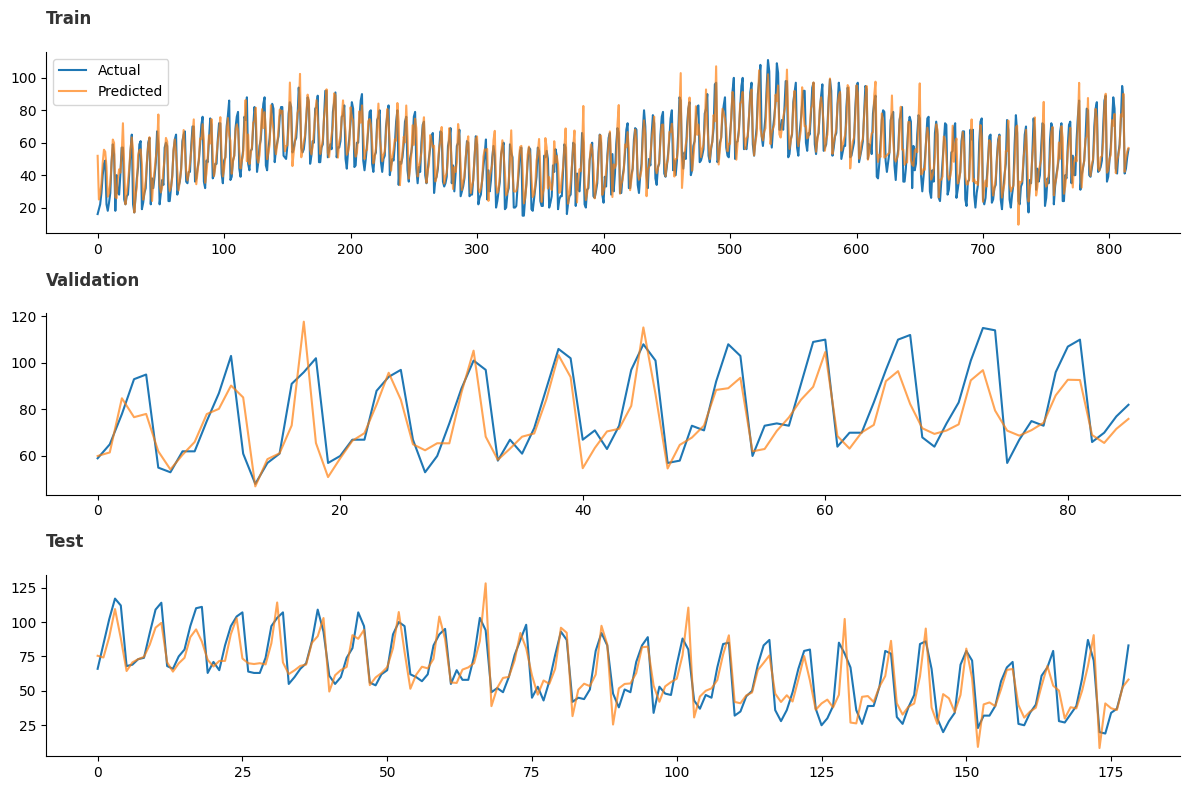

In [76]:
plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=0.7)

plt.subplot(3,1,1)
data = train_results[train_results.Dataset == 'Train']
plt.plot(data['Actuals'], label='Actual')
plt.plot(data['Predicted'], label='Predicted', alpha=0.7)
plt.title('Train', loc='left', fontweight='bold', color='#333333', pad=20)
plt.legend()

plt.subplot(3,1,2)
data = train_results[train_results.Dataset == 'Validation']
plt.plot(data['Actuals'], label='Actual')
plt.plot(data['Predicted'], label='Predicted', alpha=0.7)
plt.title('Validation', loc='left', fontweight='bold', color='#333333', pad=20)

plt.subplot(3,1,3)
data = train_results[train_results.Dataset == 'Test']
plt.plot(data['Actuals'], label='Actual')
plt.plot(data['Predicted'], label='Predicted', alpha=0.7)
plt.title('Test', loc='left', fontweight='bold', color='#333333', pad=20)

plt.tight_layout()
sns.despine()
plt.show()


### **Calculating the mean absolute percentage error (MAPE)**

In [77]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(data['Predicted'], data['Actuals'])
print(f'Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%')

Mean Absolute Percentage Error (MAPE): 18.24%


Observations:
****
- We have achieved a mean absolute percentage error of ~16% which is fairly good.
- From the plotted graph above:
  - **Train**: We see that model has learnt well from the training data and predicted values that are close to actuals.
  - **Validation**: The model does not perform that well on validation data even though predicted values follow the same pattern as actuals.
  This could be an indication that the model has overfit slightly.
  - **Test**: We see that predicted vales are much closer to actuals. Test results look more promising than validation results which means that our model is able to generalize and has not overfit.


### **Forecasting for next 3 months**

The test predicted values indicate that the model performs better when it is exposed to larger time series. We will now develop another model using the entire series for training, and use it to forecast for the next three months.

**Prepare the data**

In [78]:
# concatenate original data with synthetic data
full_data = pd.concat([sales_merged,synthetic_data])


fc1_data = full_data[['date', 'store_id', 'sales']]


# create aggregates day wise subset
fc_agg = pd.DataFrame(round(fc1_data.groupby(['date'])['sales'].mean())).reset_index()
fc_agg = fc_agg.set_index(['date'])
fc_agg.sort_index(inplace=True) # sort dates


# Fit-Transform
scaled = scaler.fit_transform(fc_agg)

# Update dataframe
fc_agg['sales'] = scaled
fc_agg.reset_index(inplace=True)
fc_agg.set_index('date', inplace=True)


# Split data into X and y
WINDOW_SIZE = 5
X_full, y_full = df_to_X_y(fc_agg, WINDOW_SIZE)
X_full.shape, y_full.shape

((1091, 5, 1, 1), (1091, 1))

**Build the model**

In [79]:

model_full = Sequential()
model_full.add(LSTM(50, return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
model_full.add(LSTM(50))
model_full.add(Dense(1))

# Saving the best model - cannot save as there is no val_loss computed to identify best model
# cp_full = ModelCheckpoint('/content/drive/MyDrive/SalesForecasting_Datasets/full_model/', save_best_only=True)

# Compile the model
model_full.compile(optimizer = 'adam',
              loss = 'mean_squared_error'
              )

# Fit the model
model_full.fit(X_full, y_full,
          epochs = 50
          )

Epoch 1/50
35/35 [==============================] - 6s 8ms/step - loss: 0.1795
Epoch 2/50
35/35 [==============================] - 0s 8ms/step - loss: 0.1706
Epoch 3/50
35/35 [==============================] - 0s 9ms/step - loss: 0.1634
Epoch 4/50
35/35 [==============================] - 0s 7ms/step - loss: 0.1434
Epoch 5/50
35/35 [==============================] - 0s 8ms/step - loss: 0.1117
Epoch 6/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0932
Epoch 7/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0828
Epoch 8/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0722
Epoch 9/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0663
Epoch 10/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0621
Epoch 11/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0573
Epoch 12/50
35/35 [==============================] - 0s 8ms/step - loss: 0.0546
Epoch 13/50
35/35 [==============================

**Make predictions**

In [80]:
# Taking the last 5 timesteps as input for makeing the next prediction
fc_input = fc_agg[- WINDOW_SIZE:]
fc_input = np.reshape(fc_input, (1, WINDOW_SIZE, 1))
fc_input

array([[[-0.94059406],
        [-0.6039604 ],
        [-0.56435644],
        [-0.26732673],
        [ 0.32673267]]])

In [81]:
fc_3mo = []
for i in range(90):
  pred = model_full.predict(fc_input).flatten()
  # Store predicted value
  fc_3mo.append(pred)
  # Append predicted value to the end of the fc_input window to make the next prediction
  fc_input = np.append(fc_input[:, 1:, :], [[pred]], axis=1)

# convert into suitable format for descaling
fc_3mo = np.array(fc_3mo).reshape(-1,1)
forecast = scaler.inverse_transform(fc_3mo).flatten()

1/1 [==============================] - 0s 23ms/step


**Create final dataframe with actuals and predicted values**

In [82]:
# Gather list of dates for each phase
train_date_list = pd.DataFrame(pd.date_range('2019-01-06','2021-03-31'), columns=['date'])
val_date_list   = pd.DataFrame(pd.date_range('2021-04-06','2021-06-30'), columns=['date'])
test_date_list  = pd.DataFrame(pd.date_range('2021-07-06','2021-12-31'), columns=['date'])
fc_date_list    = pd.DataFrame(pd.date_range('2022-01-01','2022-03-31'), columns=['date'])

# concatenate dates with predicted values
train_ds1 = train_date_list
train_ds2 = train_results[train_results.Dataset == 'Train']
train_ds  = pd.concat([train_ds1, train_ds2], axis = 1)

val_ds1 = val_date_list
val_ds2 = train_results[train_results.Dataset == 'Validation']
val_ds  = pd.concat([val_ds1, val_ds2], axis = 1)

test_ds1 = test_date_list
test_ds2 = train_results[train_results.Dataset == 'Test']
test_ds  = pd.concat([test_ds1, test_ds2], axis = 1)

fc_ds1 = fc_date_list
fc_ds2 = pd.DataFrame(data={'Dataset': 'Forecast', 'Actuals': None, 'Predicted': forecast})
fc_ds  = pd.concat([fc_ds1, fc_ds2], axis = 1)

# create final dataframe by appending all 4
ds = pd.concat([train_ds, val_ds, test_ds, fc_ds], axis = 0)
ds.shape

(1171, 4)

In [83]:
ds.head()

date Dataset  Actuals  Predicted
0 2019-01-06   Train     16.0  51.915676
1 2019-01-07   Train     19.0  24.979496
2 2019-01-08   Train     22.0  28.201834
3 2019-01-09   Train     29.0  35.202896
4 2019-01-10   Train     40.0  47.561543

**Visualizing the forecast**

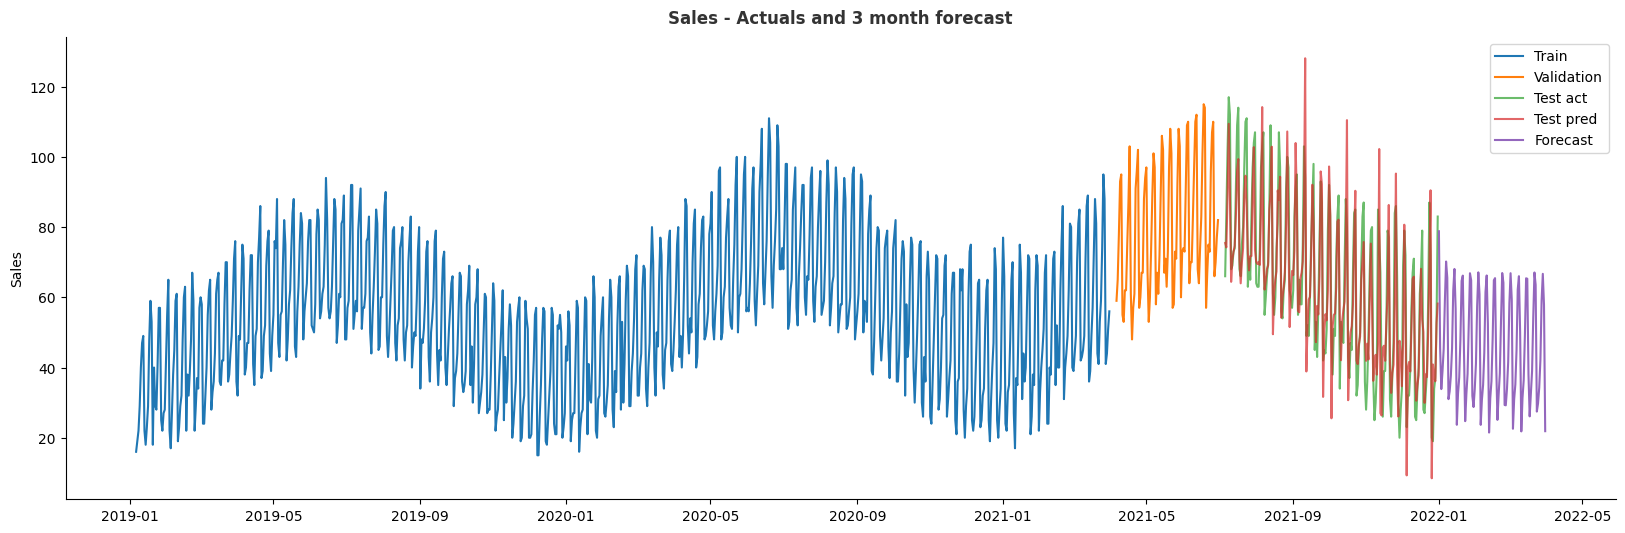

In [84]:
plt.figure(figsize=(20, 6))

train_plt = ds[ds.Dataset == 'Train']
val_plt = ds[ds.Dataset == 'Validation']
test_plt = ds[ds.Dataset == 'Test']
fc_plt = ds[ds.Dataset == 'Forecast']

plt.plot(train_plt['date'], train_plt['Actuals'], label='Train')
plt.plot(val_plt['date'], val_plt['Actuals'], label='Validation')
plt.plot(test_plt['date'], test_plt['Actuals'], label='Test act', alpha=0.7)
plt.plot(test_plt['date'], test_plt['Predicted'], label='Test pred', alpha=0.7)
plt.plot(fc_plt['date'], fc_plt['Predicted'], label='Forecast')
plt.title('Sales - Actuals and 3 month forecast', loc='center', fontweight='bold', color='#333333', pad=10)
plt.ylabel('Sales')
plt.legend()
sns.despine()
plt.show()




## End of Code